<a href="https://colab.research.google.com/github/Quaser001/scribbles_ml/blob/main/Res_Net_Progressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (2670, 113, 137, 3)
Labels distribution: HC = 1150 , PD = 1520
Modalities distribution: {np.str_('T1'): 2110, np.str_('T2'): 560}
Train: (1868, 113, 137, 3) Val: (534, 113, 137, 3) Test: (268, 113, 137, 3)


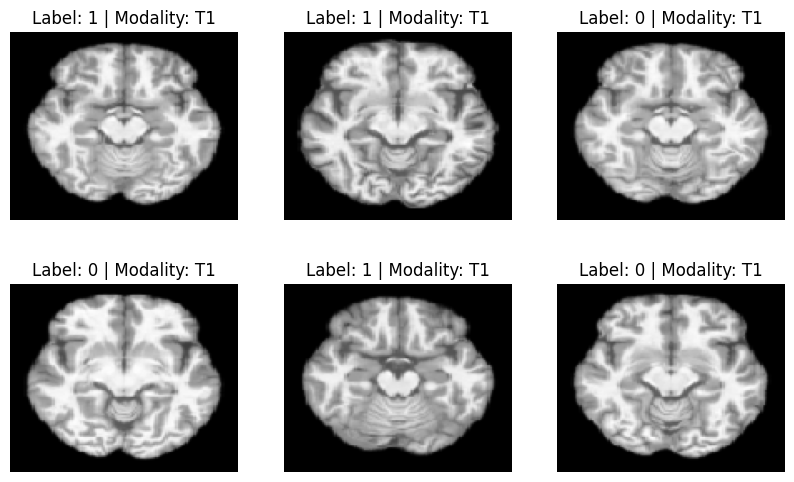

In [1]:
# =====================
# MODULE 1: Data Loading & Preprocessing
# =====================

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# -----------------
# 1. Mount Google Drive
# -----------------

# Path to your dataset (update if different)
data_dir = "/content/drive/MyDrive/xAI"

# Folder structure expected:
# data_dir/
#   T1_HC/
#   T2_HC/
#   T1_PD/
#   T2_PD/

# -----------------
# 2. Collect Images with Labels and Modality
# -----------------
IMG_SIZE = (113, 137)  # given resolution

def load_images_from_folder(folder, label, modality):
    images = []
    labels = []
    modalities = []
    files = glob.glob(os.path.join(folder, "*.png"))
    for f in files:
        img = tf.keras.preprocessing.image.load_img(f, target_size=IMG_SIZE)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # normalize
        images.append(img)
        labels.append(label)
        modalities.append(modality)
    return images, labels, modalities

# HC = 0, PD = 1
X_T1_HC, y_T1_HC, m_T1_HC = load_images_from_folder(os.path.join(data_dir, "T1_HC"), 0, "T1")
X_T2_HC, y_T2_HC, m_T2_HC = load_images_from_folder(os.path.join(data_dir, "T2_HC"), 0, "T2")
X_T1_PD, y_T1_PD, m_T1_PD = load_images_from_folder(os.path.join(data_dir, "T1_PD"), 1, "T1")
X_T2_PD, y_T2_PD, m_T2_PD = load_images_from_folder(os.path.join(data_dir, "T2_PD"), 1, "T2")

# Combine everything
X = np.array(X_T1_HC + X_T2_HC + X_T1_PD + X_T2_PD)
y = np.array(y_T1_HC + y_T2_HC + y_T1_PD + y_T2_PD)
modalities = np.array(m_T1_HC + m_T2_HC + m_T1_PD + m_T2_PD)

print("Dataset shape:", X.shape)
print("Labels distribution: HC =", sum(y==0), ", PD =", sum(y==1))
print("Modalities distribution:", {m: list(modalities).count(m) for m in set(modalities)})

# -----------------
# 3. Modality-Aware Splitting
# -----------------
def modality_aware_split(X, y, modalities, test_size=0.2, val_size=0.1):
    X_train, X_temp, y_train, y_temp, m_train, m_temp = train_test_split(
        X, y, modalities, test_size=(test_size+val_size), stratify=list(zip(y, modalities)), random_state=42
    )
    relative_val_size = val_size / (test_size+val_size)
    X_val, X_test, y_val, y_test, m_val, m_test = train_test_split(
        X_temp, y_temp, m_temp, test_size=relative_val_size, stratify=list(zip(y_temp, m_temp)), random_state=42
    )
    return (X_train, y_train, m_train), (X_val, y_val, m_val), (X_test, y_test, m_test)

(trainX, trainY, trainM), (valX, valY, valM), (testX, testY, testM) = modality_aware_split(X, y, modalities)

print("Train:", trainX.shape, "Val:", valX.shape, "Test:", testX.shape)

# -----------------
# 4. One-hot encode labels (binary)
# -----------------
trainY = to_categorical(trainY, 2)
valY = to_categorical(valY, 2)
testY = to_categorical(testY, 2)

# -----------------
# 5. Sanity Check – Show random images
# -----------------
plt.figure(figsize=(10,6))
for i in range(6):
    idx = random.randint(0, len(trainX)-1)
    plt.subplot(2,3,i+1)
    plt.imshow(trainX[idx])
    plt.title(f"Label: {np.argmax(trainY[idx])} | Modality: {trainM[idx]}")
    plt.axis("off")
plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# ============================================
# 1. Define Model (ResNet50 backbone)
# ============================================
# Corrected input shape to match IMG_SIZE (height, width, channels)
def build_resnet50(input_shape=(113, 137, 3), num_classes=2):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze base model first
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)

    # Add a Lambda layer to ensure the output is a Tensor and potentially fix SHAP compatibility
    output_tensor = Lambda(lambda x: tf.cast(x, tf.float32))(predictions) # Explicitly cast

    model = Model(inputs=base_model.input, outputs=output_tensor)
    return model

model = build_resnet50()

# ============================================
# 2. Compile Model
# ============================================
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",  # labels are integers (0=HC, 1=PD)
    metrics=["accuracy",
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall"),
             tf.keras.metrics.AUC(name="auc")]
)

model.summary()

# ============================================
# 3. Setup Callbacks
# ============================================
checkpoint_path = "/content/drive/MyDrive/ResNet50_PDvsHC/best_model.keras"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
]

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 113, 137,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 119, 143,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 57, 69,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 57, 69,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 57, 69,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 59, 71,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 29, 35,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 29, 35,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 29, 35,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 29, 35,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 29, 35,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 29, 35,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 29, 35,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 29, 35,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 29, 35,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# =========================
# MODULE 3: Progressive Training + Epoch Metrics + Save Full Model + Plots
# =========================
# Assumptions:
# - You ran Module 1 and Module 2.
# - You have trainX, trainY, trainM, valX, valY, valM, testX, testY, testM.
#   trainX shape: (N, H, W, 3), trainY int labels (0 or 1) or one-hot (we'll handle both).
# - model is built by build_resnet50() from Module 2 and compiled for binary (sparse) classification.

# If any names differ, adjust variable names accordingly.

import os, math
import numpy as np
import tensorflow as tf
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# -------------------------
# 0. Ensure GPU + Mixed precision (optional)
# -------------------------
print("TF version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)
# Optional: mixed precision for speed (only if GPU >= compute capability)
try:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    # TF 2.12+ has different API; ignore if unavailable
    print("Mixed precision not set or not available:", e)

# -------------------------
# 1. Helper: ensure labels as integers (0/1)
# -------------------------
def ensure_int_labels(y):
    y = np.array(y)
    if y.ndim == 2 and y.shape[1] == 2:
        # one-hot -> integers
        return np.argmax(y, axis=1)
    return y.astype(int)

y_train_int = ensure_int_labels(trainY)
y_val_int = ensure_int_labels(valY)
y_test_int = ensure_int_labels(testY)

# -------------------------
# 2. Balanced batch generator (modality-aware)
#    It yields balanced batches across 4 buckets: (HC/T1),(HC/T2),(PD/T1),(PD/T2)
# -------------------------
def build_buckets_indices(labels, modalities):
    # modalities are strings or ints (e.g., "T1"/"T2" or 0/1). Normalize to 0/1
    mod_arr = np.array(modalities)
    if mod_arr.dtype.kind in 'UO':  # string -> convert T1->0, T2->1
        mod_arr = np.array([0 if str(m).upper().startswith('T1') else 1 for m in mod_arr])
    else:
        mod_arr = mod_arr.astype(int)
    buckets = {}
    # keys: (label, modality)
    for lab in [0,1]:
        for mod in [0,1]:
            idxs = np.where((labels==lab) & (mod_arr==mod))[0].tolist()
            buckets[(lab, mod)] = idxs
    return buckets

train_buckets = build_buckets_indices(y_train_int, trainM)

def balanced_batch_generator(X, y, modalities, batch_size=32):
    buckets = build_buckets_indices(y, modalities)
    keys = list(buckets.keys())  # four keys
    per_bucket = max(1, batch_size // len(keys))
    idx_order = []
    # Create epoch-wise ordering by sampling equally from buckets
    # If bucket smaller than per_bucket, sample with replacement
    max_len = max(len(buckets[k]) for k in keys)
    rounds = math.ceil(max_len / per_bucket)
    for r in range(rounds):
        batch_idxs = []
        for k in keys:
            bucket = buckets[k]
            if len(bucket) == 0:
                continue
            # sample per_bucket indices (with replacement if not enough)
            if len(bucket) >= per_bucket:
                chosen = np.random.choice(bucket, per_bucket, replace=False).tolist()
            else:
                chosen = np.random.choice(bucket, per_bucket, replace=True).tolist()
            batch_idxs += chosen
        # if too many, trim
        if len(batch_idxs) > batch_size:
            batch_idxs = batch_idxs[:batch_size]
        np.random.shuffle(batch_idxs)
        # yield X_batch, y_batch
        X_batch = X[batch_idxs]
        y_batch = y[batch_idxs]
        yield X_batch, y_batch

# Quick sanity: count in buckets
print("Train bucket counts:")
for k,v in train_buckets.items():
    print(k, len(v))

# -------------------------
# 3. Class weights for imbalance
# -------------------------
# HC total, PD total
N_HC = len(np.where(y_train_int==0)[0]) + len(np.where(y_val_int==0)[0]) + len(np.where(y_test_int==0)[0])
N_PD = len(np.where(y_train_int==1)[0]) + len(np.where(y_val_int==1)[0]) + len(np.where(y_test_int==1)[0])
# Alternatively use only training counts:
N_HC_train = len(np.where(y_train_int==0)[0])
N_PD_train = len(np.where(y_train_int==1)[0])
total_train = N_HC_train + N_PD_train
w_HC = total_train / (2 * max(1, N_HC_train))
w_PD = total_train / (2 * max(1, N_PD_train))
class_weights = {0: w_HC, 1: w_PD}
print("Using class weights:", class_weights)

# -------------------------
# 4. Custom callback to compute per-epoch metrics (including F1 & ROC AUC)
# -------------------------
class PerEpochMetrics(tf.keras.callbacks.Callback):
    def __init__(self, val_data, val_labels, batch_size=64, save_history=True):
        super().__init__()
        self.val_X = np.array(val_data)
        self.val_y = np.array(val_labels)
        self.batch_size = batch_size
        self.history = {"val_acc":[], "val_precision":[], "val_recall":[], "val_f1":[], "val_auc":[], "val_loss":[]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # predict on validation set
        preds_prob = self.model.predict(self.val_X, batch_size=self.batch_size, verbose=0)
        if preds_prob.ndim == 2 and preds_prob.shape[1] == 2:
            probs = preds_prob[:,1]
            preds = np.argmax(preds_prob, axis=1)
        else:
            probs = preds_prob.ravel()
            preds = (probs > 0.5).astype(int)
        y_true = np.array(self.val_y).astype(int)

        acc = accuracy_score(y_true, preds)
        prec = precision_score(y_true, preds, zero_division=0)
        rec = recall_score(y_true, preds, zero_division=0)
        f1 = f1_score(y_true, preds, zero_division=0)
        try:
            auc_score = roc_auc_score(y_true, probs)
        except Exception:
            auc_score = float("nan")

        self.history["val_acc"].append(acc)
        self.history["val_precision"].append(prec)
        self.history["val_recall"].append(rec)
        self.history["val_f1"].append(f1)
        self.history["val_auc"].append(auc_score)
        self.history["val_loss"].append(logs.get("val_loss"))

        print(f" --> Val epoch {epoch+1}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}, auc={auc_score:.4f}")


TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision not set or not available: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (/usr/local/lib/python3.12/dist-packages/keras/_tf_keras/keras/mixed_precision/__init__.py)
Train bucket counts:
(0, 0) 413
(0, 1) 392
(1, 0) 1063
(1, 1) 0
Using class weights: {0: 1.160248447204969, 1: 0.878645343367827}


In [10]:

# -------------------------
# 5. Training stages (progressive unfreeze)
#    Stage 1: train head only (base frozen)
#    Stage 2: unfreeze last conv block (layer4) + head
#    Stage 3: optionally unfreeze all with low LR
# -------------------------
# Rebuild model if needed (input shape must match your images). If your Module2 `model` exists, use it.
try:
    model  # if model exists from Module2
    print("Using existing model variable.")
except NameError:
    # build again (adjust input shape if your images are different shape)
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
    from tensorflow.keras.models import Model
    base = ResNet50(weights='imagenet', include_top=False, input_shape=trainX.shape[1:])
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    out = Dense(2, activation='softmax', dtype='float32')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Rebuilt model.")

# ensure model is compiled for training
model.summary()

Using existing model variable.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 137, 113,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 143, 119,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 69, 57,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 69, 57,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 69, 57,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 71, 59,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 35, 29,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 35, 29,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 35, 29,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 35, 29,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 35, 29,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 35, 29,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 35, 29,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 35, 29,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 35, 29,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 35, 29,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 35, 29,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# define checkpoint path for saving the full model (SavedModel format recommended)
save_dir = "/content/drive/MyDrive/ResNet50_PDvsHC"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, "best_full_model.keras")  # keras .keras single-file
print("Model will be saved to:", best_model_path)

# Stage helper
def set_trainable_layers(model, trainable_layer_prefixes):
    # trainable_layer_prefixes: list of string prefixes to allow training (e.g., ["conv5_block1","conv5_block2"] or layer names)
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers:
        for pref in trainable_layer_prefixes:
            if layer.name.startswith(pref):
                layer.trainable = True
    # Always allow the top Dense to be trainable
    if model.layers:
        model.layers[-1].trainable = True
    # recompile after changing trainable flags
    return

Model will be saved to: /content/drive/MyDrive/ResNet50_PDvsHC/best_full_model.keras



=== Stage 1: head-only training (base frozen) ===
Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6693 - loss: 0.5199 --> Val epoch 1: acc=0.4326, prec=1.0000, rec=0.0033, f1=0.0066, auc=0.7397

Epoch 1: val_loss improved from inf to 0.67108, saving model to /content/drive/MyDrive/ResNet50_PDvsHC/best_full_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 356ms/step - accuracy: 0.6692 - loss: 0.5199 - val_accuracy: 0.4326 - val_loss: 0.6711
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6838 - loss: 0.5121 --> Val epoch 2: acc=0.4363, prec=1.0000, rec=0.0099, f1=0.0195, auc=0.7403

Epoch 2: val_loss improved from 0.67108 to 0.66087, saving model to /content/drive/MyDrive/ResNet50_PDvsHC/best_full_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6837 - loss: 0.5121 - val_accuracy: 0.4363 - val_loss: 0.6609
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6779 - loss: 0.5070 --> Val epoch 3: acc=0.4307, prec=0.0000, rec=0.0000, f

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 113, 137,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 119, 143,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 57, 69,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 57, 69,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 57, 69,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 59, 71,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 29, 35,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 29, 35,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 29, 35,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 29, 35,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 29, 35,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 29, 35,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 29, 35,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 29, 35,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 29, 35,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_3_c

 Total params: 70,669,192 (269.58 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,077,382 (179.59 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Test metrics -> Acc: 0.4291, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, AUC: 0.3933
Confusion Matrix:
 [[115   0]
 [153   0]]


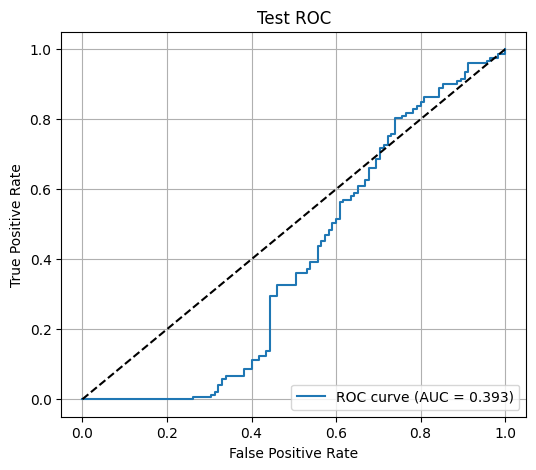

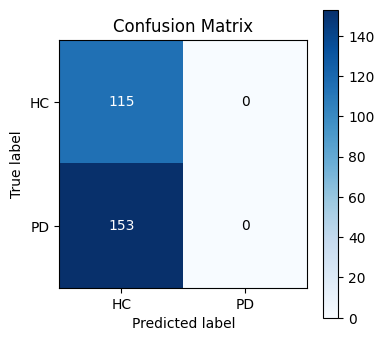

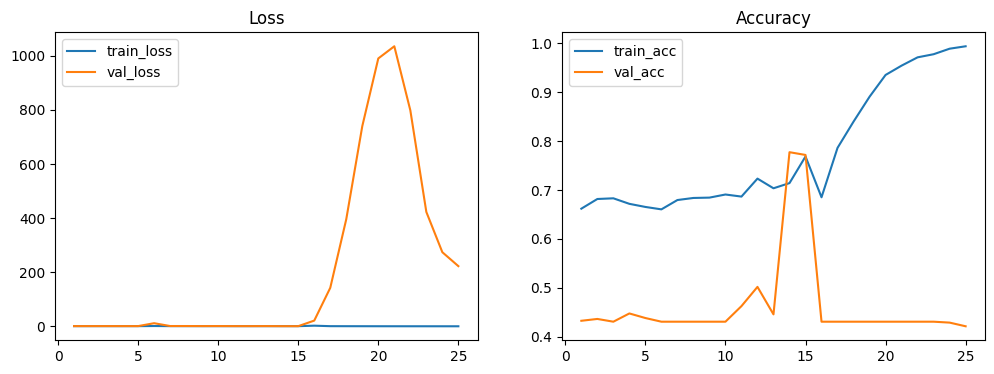

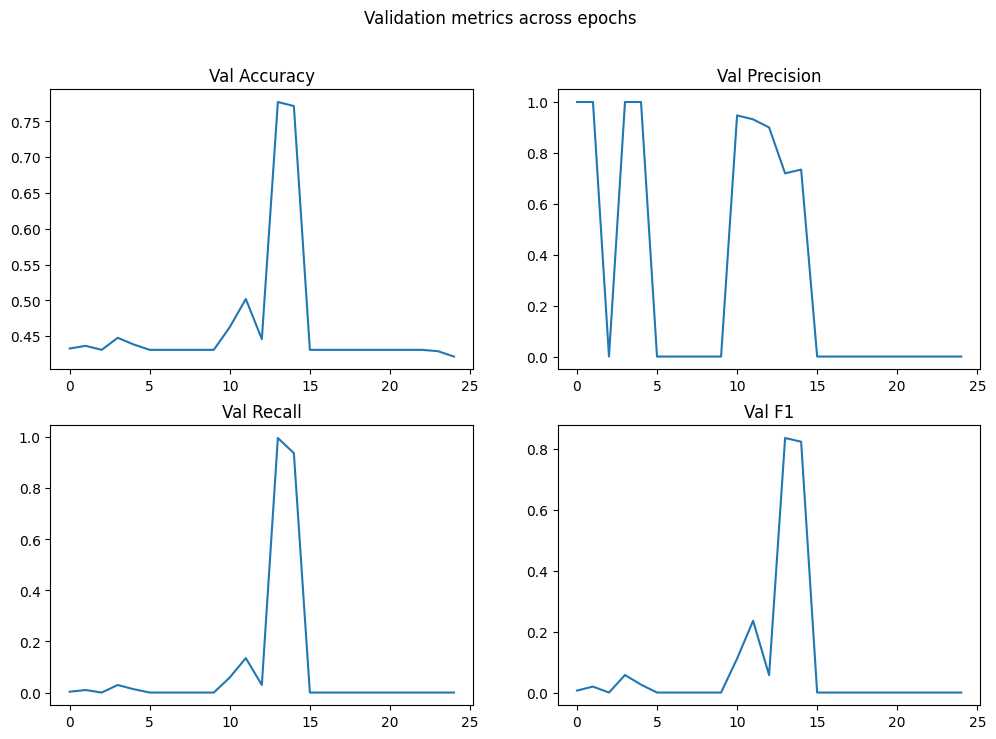

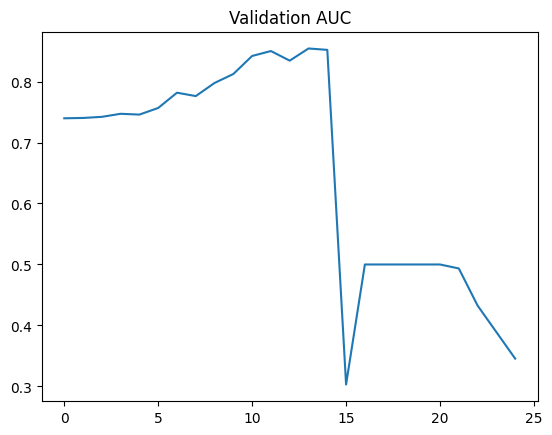

Saved final model to: /content/drive/MyDrive/ResNet50_PDvsHC/final_best_model.keras
Module 3 complete. You can now run Module 4 (Explainability) which will use the saved model for Grad-CAM++ and SHAP.


In [17]:
# -------------------------
# 6. Stage 1: head-only training
# -------------------------
print("\n=== Stage 1: head-only training (base frozen) ===")
for layer in model.layers:
    layer.trainable = False
# unfreeze final classification head (last Dense)
model.layers[-1].trainable = True

# compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbacks
epoch_metrics_cb = PerEpochMetrics(valX, y_val_int, batch_size=64)
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', verbose=1)
earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train generator using balanced batches (we use numpy arrays here)
batch_size = 32
steps_per_epoch = max(1, math.ceil(len(trainX) / batch_size))
# Create the generator here, but don't start iterating yet
# train_gen = balanced_batch_generator(trainX, y_train_int, trainM, batch_size=batch_size)


# Fit using generator: wrap generator as tf.data
def gen_to_tfdata(X, y, modalities, batch_size):
    def _gen():
        # Recreate the generator whenever it's exhausted
        gen = balanced_batch_generator(X, y, modalities, batch_size=batch_size)
        while True:
            try:
                Xb, yb = next(gen)
                yield Xb.astype(np.float32), yb.astype(np.int32)
            except StopIteration:
                # If the generator is exhausted, recreate it and continue
                gen = balanced_batch_generator(X, y, modalities, batch_size=batch_size)
                Xb, yb = next(gen) # Get the first batch from the new generator
                yield Xb.astype(np.float32), yb.astype(np.int32)

    # Explicitly set the output shape for labels
    out_shapes = (tf.TensorShape([None, *trainX.shape[1:]]), tf.TensorShape([None]))
    ds = tf.data.Dataset.from_generator(_gen, output_types=(tf.float32, tf.int32), output_shapes=out_shapes)
    # No need for .repeat() here as the Python generator handles repetition
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Use a generator directly in fit is easier: but Keras expects either Python Sequence or tf.data; we'll use tf.data with steps_per_epoch
tf_train_ds = gen_to_tfdata(trainX, y_train_int, trainM, batch_size)
history_stage1 = model.fit(tf_train_ds,
                           epochs=5,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=(valX, y_val_int),
                           callbacks=[epoch_metrics_cb, ckpt_cb, earlystop_cb],
                           class_weight=class_weights,
                           verbose=1)

# -------------------------
# 7. Stage 2: unfreeze last conv block (layer4) + head
# -------------------------
print("\n=== Stage 2: unfreeze last conv block (layer4) + head ===")
# For Keras ResNet50, block names include 'conv5_block' for the last stage.
for layer in model.layers:
    if layer.name.startswith('conv5_block') or layer.name.startswith('conv5_'):
        layer.trainable = True
    # keep earlier layers frozen
# also ensure classifier head trainable
model.layers[-1].trainable = True

# compile with a smaller LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#train again
epoch_metrics_cb2 = PerEpochMetrics(valX, y_val_int, batch_size=64)
ckpt_cb2 = tf.keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', verbose=1)
history_stage2 = model.fit(tf_train_ds,
                           epochs=10,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=(valX, y_val_int),
                           callbacks=[epoch_metrics_cb2, ckpt_cb2, tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)],
                           class_weight=class_weights,
                           verbose=1)

# -------------------------
# 8. Stage 3 (optional): unfreeze all layers with discriminative LR (final fine-tune)
# -------------------------
print("\n=== Stage 3: unfreeze all layers for fine-tuning (optional) ===")
for layer in model.layers:
    layer.trainable = True

# compile with lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epoch_metrics_cb3 = PerEpochMetrics(valX, y_val_int, batch_size=64)
ckpt_cb3 = tf.keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', verbose=1)

history_stage3 = model.fit(tf_train_ds,
                           epochs=10,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=(valX, y_val_int),
                           callbacks=[epoch_metrics_cb3, ckpt_cb3],
                           class_weight=class_weights,
                           verbose=1)

# -------------------------
# 9. Load best saved model (full model) and evaluate on test set
# -------------------------
print("\nLoading best saved model from:", best_model_path)
best_model = tf.keras.models.load_model(best_model_path)
best_model.summary()

# Evaluate on test set
preds_prob_test = best_model.predict(testX, batch_size=64, verbose=1)
if preds_prob_test.ndim == 2 and preds_prob_test.shape[1] == 2:
    probs_test = preds_prob_test[:,1]
    preds_test = np.argmax(preds_prob_test, axis=1)
else:
    probs_test = preds_prob_test.ravel()
    preds_test = (probs_test > 0.5).astype(int)

acc_test = accuracy_score(y_test_int, preds_test)
prec_test = precision_score(y_test_int, preds_test, zero_division=0)
rec_test = recall_score(y_test_int, preds_test, zero_division=0)
f1_test = f1_score(y_test_int, preds_test, zero_division=0)
auc_test = roc_auc_score(y_test_int, probs_test)

print(f"Test metrics -> Acc: {acc_test:.4f}, Prec: {prec_test:.4f}, Rec: {rec_test:.4f}, F1: {f1_test:.4f}, AUC: {auc_test:.4f}")

# -------------------------
# 10. Confusion matrix and ROC curve
# -------------------------
cm = confusion_matrix(y_test_int, preds_test)
print("Confusion Matrix:\n", cm)

# ROC curve
fpr, tpr, thresh = roc_curve(y_test_int, probs_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.xticks([0,1], ['HC','PD'])
plt.yticks([0,1], ['HC','PD'])
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center', color='white' if z > cm.max()/2 else 'black')
plt.show()

# -------------------------
# 11. Plot training curves (loss/accuracy and the extra metrics collected)
# -------------------------
# collect histories and per-epoch metrics from callbacks
# Combine histories if needed (stage1+stage2+stage3)
def concat_histories(*hist_list):
    h = {'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}
    for hist in hist_list:
        if hasattr(hist, 'history'):
            hh = hist.history
            for k in h.keys():
                h[k] += hh.get(k, [])
    return h

h_all = concat_histories(history_stage1, history_stage2, history_stage3)
# use epoch_metrics_cb.history dictionaries for val metrics per stage:
val_hist_all = {}
val_hist_all['val_acc'] = epoch_metrics_cb.history['val_acc'] + epoch_metrics_cb2.history['val_acc'] + epoch_metrics_cb3.history['val_acc']
val_hist_all['val_precision'] = epoch_metrics_cb.history['val_precision'] + epoch_metrics_cb2.history['val_precision'] + epoch_metrics_cb3.history['val_precision']
val_hist_all['val_recall'] = epoch_metrics_cb.history['val_recall'] + epoch_metrics_cb2.history['val_recall'] + epoch_metrics_cb3.history['val_recall']
val_hist_all['val_f1'] = epoch_metrics_cb.history['val_f1'] + epoch_metrics_cb2.history['val_f1'] + epoch_metrics_cb3.history['val_f1']
val_hist_all['val_auc'] = epoch_metrics_cb.history['val_auc'] + epoch_metrics_cb2.history['val_auc'] + epoch_metrics_cb3.history['val_auc']

# Plot Loss & Accuracy (training history)
epochs_range = range(1, len(h_all['loss'])+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, h_all['loss'], label='train_loss')
plt.plot(epochs_range, h_all['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_range, h_all['accuracy'], label='train_acc')
plt.plot(epochs_range, h_all['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.show()

# Plot Val precision/recall/f1/auc across epochs
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.plot(val_hist_all['val_acc']); plt.title("Val Accuracy")
plt.subplot(2,2,2); plt.plot(val_hist_all['val_precision']); plt.title("Val Precision")
plt.subplot(2,2,3); plt.plot(val_hist_all['val_recall']); plt.title("Val Recall")
plt.subplot(2,2,4); plt.plot(val_hist_all['val_f1']); plt.title("Val F1")
plt.suptitle("Validation metrics across epochs")
plt.show()

plt.figure(); plt.plot(val_hist_all['val_auc']); plt.title("Validation AUC"); plt.show()

# -------------------------
# 12. Save final best model again (explicit)
# -------------------------
final_save_path = os.path.join(save_dir, "final_best_model.keras")
best_model.save(final_save_path)
print("Saved final model to:", final_save_path)

# Module 3 complete.
print("Module 3 complete. You can now run Module 4 (Explainability) which will use the saved model for Grad-CAM++ and SHAP.")

In [20]:
# ============================
# MODULE 4: Explainability - Grad-CAM++ (tf-keras-vis) + SHAP
# ============================

# 0) Install required libs (run once)
!pip install -q tf-keras-vis==0.8.7 shap==0.42.1 matplotlib opencv-python

# 1) Imports
import os, numpy as np, matplotlib.pyplot as plt, cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras import backend as K
import shap

# tf-keras-vis imports
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize

# 2) Paths & device check
DRIVE_SAVE_DIR = "/content/drive/MyDrive/ResNet50_PDvsHC"
BEST_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, "best_full_model.keras")  # adjust if different
FINAL_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, "final_best_model.keras")  # fallback
if not os.path.exists(BEST_MODEL_PATH):
    if os.path.exists(FINAL_MODEL_PATH):
        BEST_MODEL_PATH = FINAL_MODEL_PATH
print("Loading model from:", BEST_MODEL_PATH)

print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# 3) Load model
# If you used mixed precision and saved custom dtype, this should still load. If it errors, try custom_objects.
model = load_model(BEST_MODEL_PATH)
model.summary()

# 4) Helpers: preprocess / deprocess images (match training preprocessing)
# If training normalized images to [0,1], we will use that. If you normalized with ImageNet mean/std, replicate here.
# Module 1 used images in [0,1] (divided by 255). Module2 used ResNet50 (imagenet weights) which expects images scaled as:
#   either [-1,1] or with imagemtn mean/std. We assume you used [0,1] during training (Module1). If you used ImageNet preprocess, replace with tf.keras.applications.resnet50.preprocess_input

def preprocess_image_np(img_np, target_size=None):
    """ img_np: HxWxC in range [0,1] or 0-255. Returns batched float32 [1,H,W,C] in same scale as training """
    if img_np.max() > 1.1:
        img_np = img_np.astype(np.float32) / 255.0
    if target_size is not None:
        img_np = cv2.resize(img_np, (target_size[1], target_size[0]), interpolation=cv2.INTER_AREA)
    # ensure shape HWC and 3 channels
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    if img_np.shape[2] == 1:
        img_np = np.concatenate([img_np]*3, axis=-1)
    return np.expand_dims(img_np.astype(np.float32), axis=0)

def deprocess_for_display(img_batch):
    """ img_batch: [B,H,W,C] in [0,1] -> return HxW x3 in [0,1] """
    img = img_batch[0]
    img = np.clip(img, 0, 1)
    return img

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.7/402.7 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00
Loading model from: /content/drive/MyDrive/ResNet50_PDvsHC/best_full_model.keras
TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 113, 137,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 119, 143,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 57, 69,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 57, 69,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 57, 69,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 59, 71,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 29, 35,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 29, 35,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 29, 35,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 29, 35,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 29, 35,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 29, 35,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 29, 35,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 29, 35,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 29, 35,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_3_c

 Total params: 70,669,192 (269.58 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,077,382 (179.59 MB)

Using in-memory testX array of shape (268, 113, 137, 3)
Selected indices for explainability: [27, 192, 181, 206, 12, 67, 209, 162, 158]
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


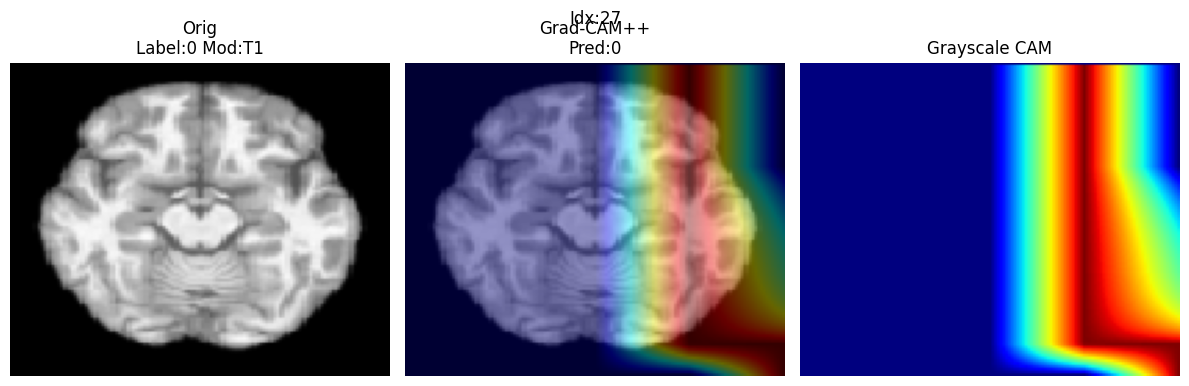

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


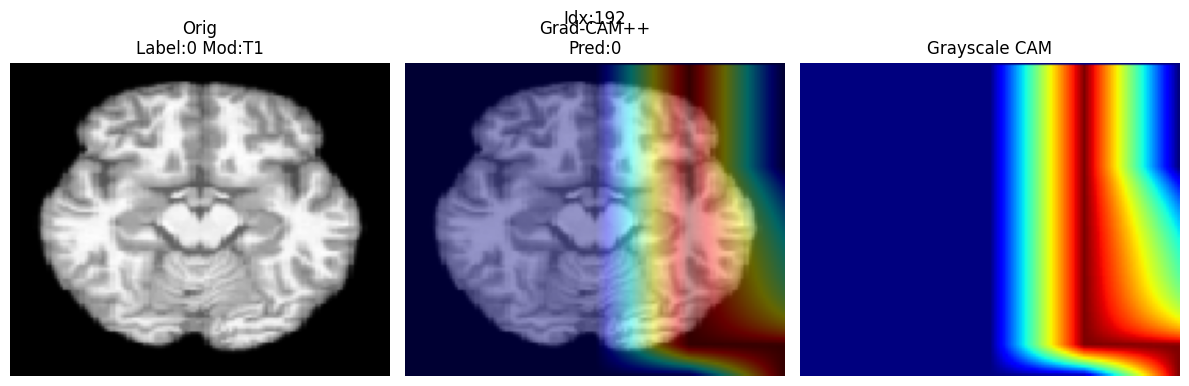

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


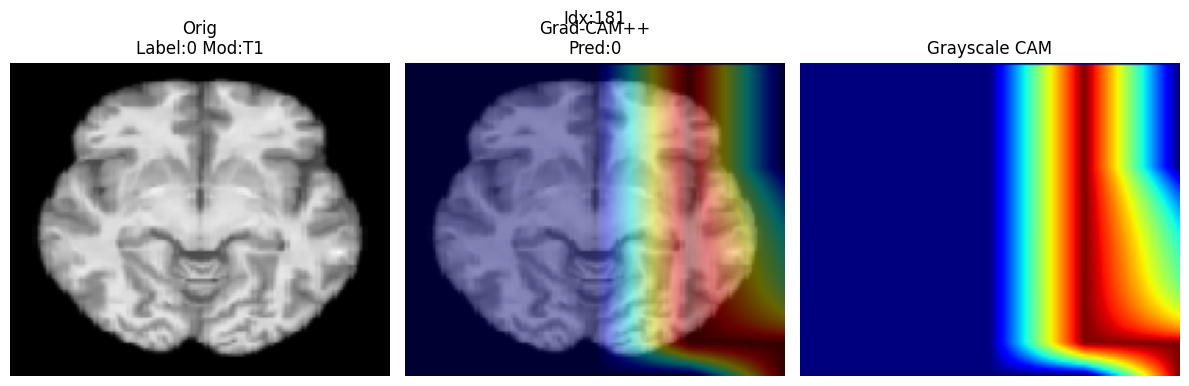

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


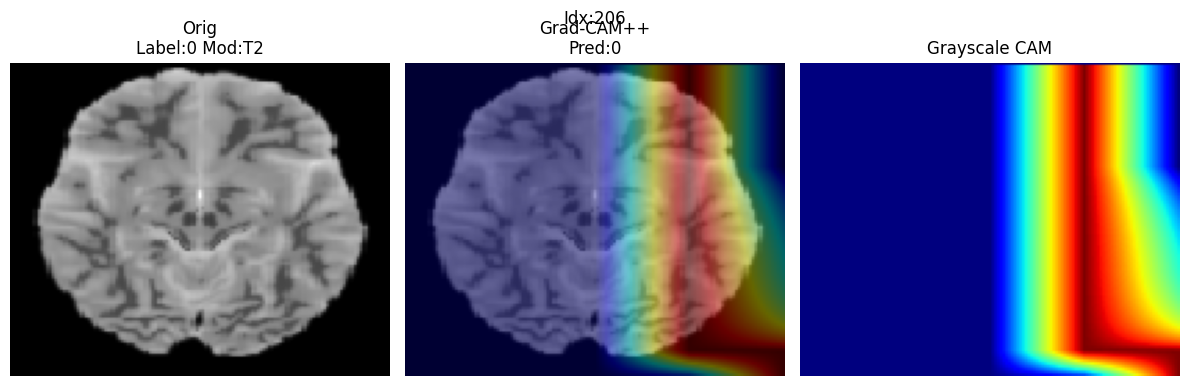

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


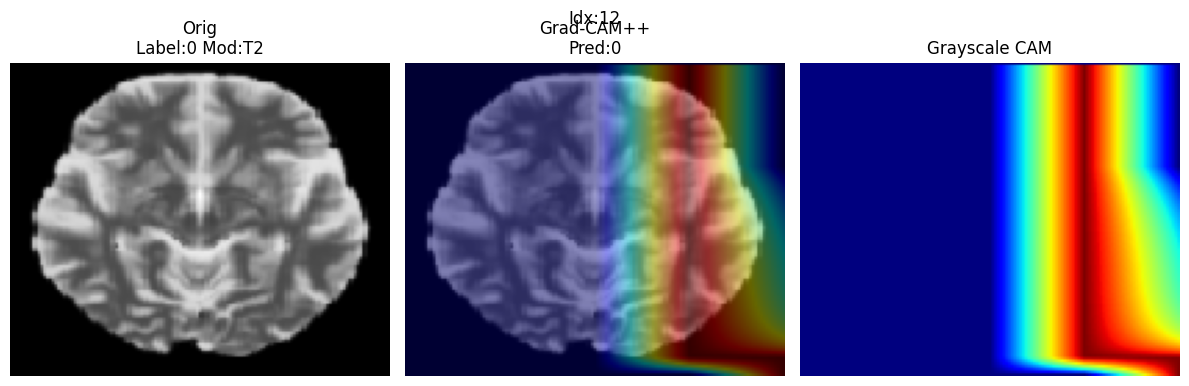

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


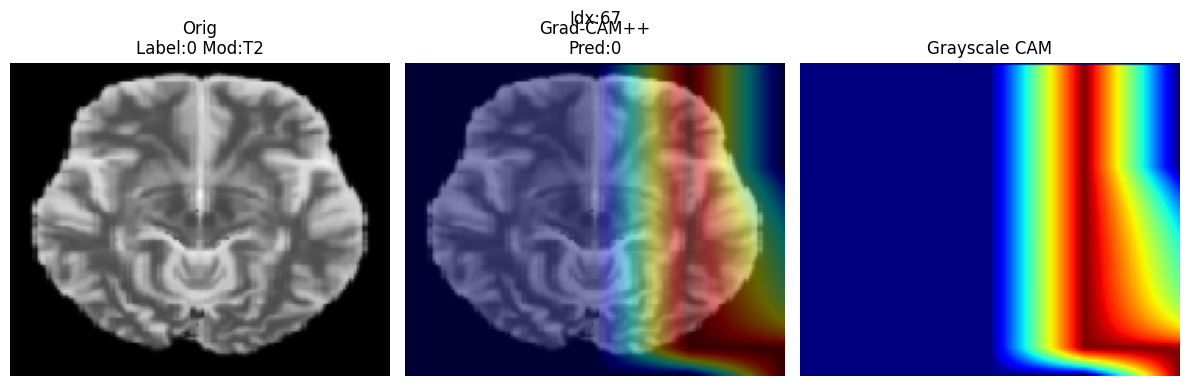

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


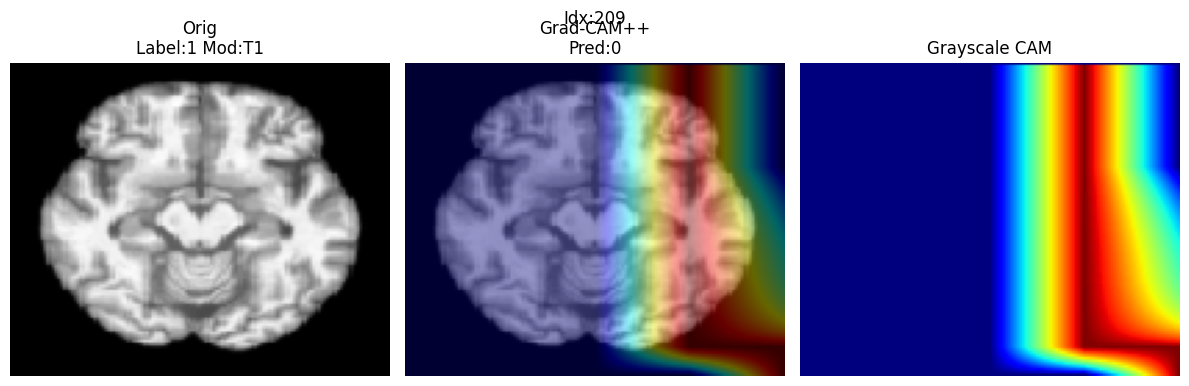

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


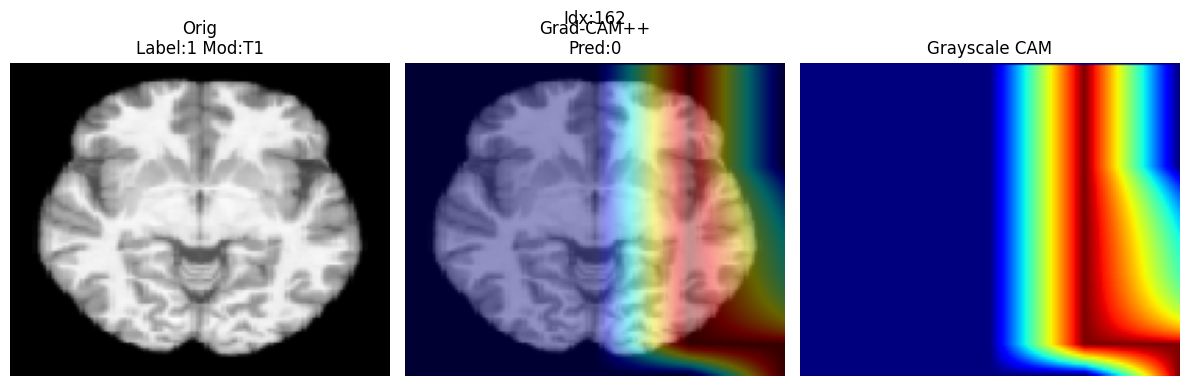

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


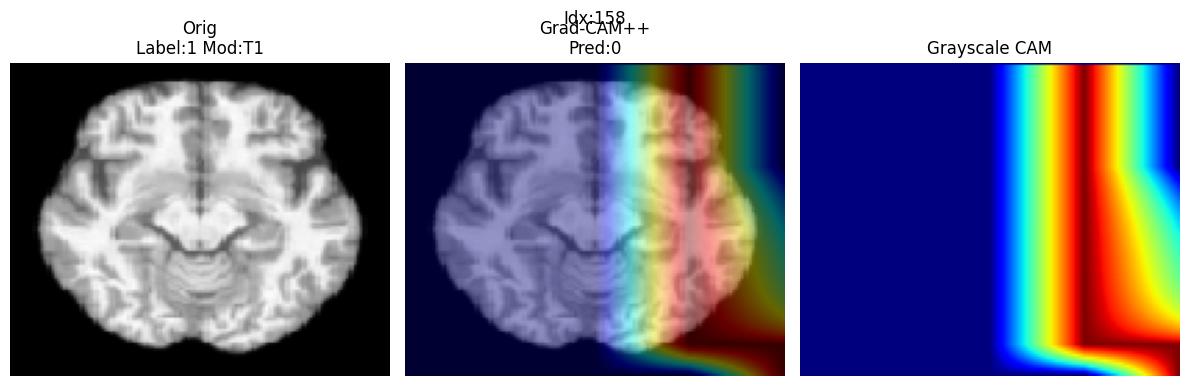

Saved Grad-CAM++ visualizations to /content/drive/MyDrive/ResNet50_PDvsHC/explainability_outputs


In [21]:

# 5) Prepare a small test subset for explanation
# If you have testX as numpy images and testM as modalities array (e.g., "T1"/"T2" or 0/1), use them.
# Otherwise, if you only have file paths, adapt to load from the paths.

# We'll try to use testX variable if available in workspace (from Module 1/3)
try:
    _ = testX
    print("Using in-memory testX array of shape", testX.shape)
    TEST_IMAGES = testX  # numpy [N,H,W,3]
    TEST_LABELS = np.array(y_test_int)
    TEST_MODALITIES = np.array(testM)
except Exception as e:
    # Replace this with code to load images from file paths if you don't have testX
    raise RuntimeError("testX not found in workspace. Please load your test images as numpy array testX, labels y_test_int, modalities testM.") from e

# Convert modalities to readable form if necessary
mod_arr = np.array(TEST_MODALITIES)
if mod_arr.dtype.kind in 'i':
    # assume 0=T1,1=T2
    mod_str = np.array(['T1' if m==0 else 'T2' for m in mod_arr])
else:
    mod_str = mod_arr

# 6) Grad-CAM++ setup using tf-keras-vis
# Replace final activation with linear for saliency computation (tf-keras-vis helper does this)
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=False)

# utility to run gradcam++ and return heatmap overlay
def compute_and_show_gradcam(img_np, class_idx=None, grayscale_cam_blend=0.5):
    """
    img_np: HxWxC in [0,1] (unbatched)
    class_idx: int class to explain (0 or 1). If None, model prediction will be used.
    returns: visualization image (H,W,3), grayscale_cam map
    """
    H, W = img_np.shape[:2]
    inp = preprocess_image_np(img_np, target_size=(H,W))  # returns [1,H,W,3]
    # model_pred
    preds = model.predict(inp)
    if preds.ndim == 2 and preds.shape[1] == 2:
        pred_class = int(np.argmax(preds[0]))
    else:
        pred_class = int((preds.ravel() > 0.5).astype(int))
    if class_idx is None:
        class_idx = pred_class
    # score function for class index
    score = CategoricalScore([class_idx])
    # compute cam (returns [batch, H, W])
    cam = gradcam(score, inp, penultimate_layer=-1)  # penultimate_layer can be set, -1 uses last conv layer
    grayscale_cam = cam[0]  # HxW
    # normalize cam to 0..1
    grayscale_cam = normalize(grayscale_cam)
    # overlay heatmap on original image (convert to uint8)
    img_disp = (img_np * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap((grayscale_cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.6 * img_disp + 0.4 * heatmap).astype(np.uint8)
    return overlay, grayscale_cam, pred_class

# 7) Run Grad-CAM++ on a sample of test images and save results
OUT_DIR = os.path.join(DRIVE_SAVE_DIR, "explainability_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

num_examples = 12  # change as desired
indices = np.arange(len(TEST_IMAGES))
# pick stratified by class and modality: choose equal numbers
sel_idx = []
for lab in [0,1]:
    for mod in ['T1','T2']:
        mask = np.where((TEST_LABELS==lab) & (mod_str==mod))[0]
        if len(mask) == 0: continue
        pick = np.random.choice(mask, min(3, len(mask)), replace=False).tolist()  # up to 3 each bucket
        sel_idx += pick
sel_idx = sel_idx[:num_examples]

print("Selected indices for explainability:", sel_idx)

gradcam_results = []
for i in sel_idx:
    img = TEST_IMAGES[i]
    lab = int(TEST_LABELS[i])
    mod = mod_str[i]
    overlay, cam_map, pred = compute_and_show_gradcam(img, class_idx=None)
    # plot side-by-side original, overlay, cam
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img); axes[0].set_title(f"Orig\nLabel:{lab} Mod:{mod}"); axes[0].axis('off')
    axes[1].imshow(overlay); axes[1].set_title(f"Grad-CAM++\nPred:{pred}"); axes[1].axis('off')
    axes[2].imshow(cam_map, cmap='jet'); axes[2].set_title('Grayscale CAM'); axes[2].axis('off')
    plt.suptitle(f"Idx:{i}")
    plt.tight_layout()
    savep = os.path.join(OUT_DIR, f"gradcam_idx{i}_lab{lab}_mod{mod}_pred{pred}.png")
    plt.savefig(savep, bbox_inches='tight', dpi=150)
    plt.show()
    gradcam_results.append((i, savep))
print("Saved Grad-CAM++ visualizations to", OUT_DIR)

In [40]:
# ============================
# MODULE 4: Explainability - Grad-CAM++ (tf-keras-vis) + SHAP
# ============================

# 0) Install required libs (run once)
!pip install -q tf-keras-vis==0.8.7 shap==0.42.1 matplotlib opencv-python

# 1) Imports
import os, numpy as np, matplotlib.pyplot as plt, cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras import backend as K
import shap

# tf-keras-vis imports
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize

# 2) Paths & device check
DRIVE_SAVE_DIR = "/content/drive/MyDrive/ResNet50_PDvsHC"
BEST_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, "best_full_model.keras")  # adjust if different
FINAL_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, "final_best_model.keras")  # fallback
if not os.path.exists(BEST_MODEL_PATH):
    if os.path.exists(FINAL_MODEL_PATH):
        BEST_MODEL_PATH = FINAL_MODEL_PATH
print("Loading model from:", BEST_MODEL_PATH)

print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# 3) Load model
# If you used mixed precision and saved custom dtype, this should still load. If it errors, try custom_objects.
model = load_model(BEST_MODEL_PATH)
model.summary()

# 4) Helpers: preprocess / deprocess images (match training preprocessing)
# If training normalized images to [0,1], we will use that. If you normalized with ImageNet mean/std, replicate here.
# Module 1 used images in [0,1] (divided by 255). Module2 used ResNet50 (imagenet weights) which expects images scaled as:
#   either [-1,1] or with imagemtn mean/std. We assume you used [0,1] during training (Module1). If you used ImageNet preprocess, replace with tf.keras.applications.resnet50.preprocess_input

def preprocess_image_np(img_np, target_size=None):
    """ img_np: HxWxC in range [0,1] or 0-255. Returns batched float32 [1,H,W,C] in same scale as training """
    if img_np.max() > 1.1:
        img_np = img_np.astype(np.float32) / 255.0
    if target_size is not None:
        img_np = cv2.resize(img_np, (target_size[1], target_size[0]), interpolation=cv2.INTER_AREA)
    # ensure shape HWC and 3 channels
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    if img_np.shape[2] == 1:
        img_np = np.concatenate([img_np]*3, axis=-1)
    return np.expand_dims(img_np.astype(np.float32), axis=0)

def deprocess_for_display(img_batch):
    """ img_batch: [B,H,W,C] in [0,1] -> return HxW x3 in [0,1] """
    img = img_batch[0]
    img = np.clip(img, 0, 1)
    return img


Loading model from: /content/drive/MyDrive/ResNet50_PDvsHC/best_full_model.keras
TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 113, 137,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 119, 143,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 57, 69,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 57, 69,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 57, 69,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 59, 71,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 29, 35,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 29, 35,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 29, 35,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 29, 35,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 29, 35,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 29, 35,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 29, 35,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 29, 35,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 29, 35,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_3_c

 Total params: 70,669,192 (269.58 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,077,382 (179.59 MB)

In [43]:

# 5) Prepare a small test subset for explanation
# If you have testX as numpy images and testM as modalities array (e.g., "T1"/"T2" or 0/1), use them.
# Otherwise, if you only have file paths, adapt to load from the paths.

# We'll try to use testX variable if available in workspace (from Module 1/3)
try:
    _ = testX
    print("Using in-memory testX array of shape", testX.shape)
    TEST_IMAGES = testX  # numpy [N,H,W,3]
    TEST_LABELS = np.array(y_test_int)
    TEST_MODALITIES = np.array(testM)
except Exception as e:
    # Replace this with code to load images from file paths if you don't have testX
    raise RuntimeError("testX not found in workspace. Please load your test images as numpy array testX, labels y_test_int, modalities testM.") from e

# Convert modalities to readable form if necessary
mod_arr = np.array(TEST_MODALITIES)
if mod_arr.dtype.kind in 'i':
    # assume 0=T1,1=T2
    mod_str = np.array(['T1' if m==0 else 'T2' for m in mod_arr])
else:
    mod_str = mod_arr

Using in-memory testX array of shape (268, 113, 137, 3)


In [46]:

# 6) Grad-CAM++ setup using tf-keras-vis
# Replace final activation with linear for saliency computation (tf-keras-vis helper does this)
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=False)

# utility to run gradcam++ and return heatmap overlay
def compute_and_show_gradcam(img_np, class_idx=None, grayscale_cam_blend=0.5):
    """
    img_np: HxWxC in [0,1] (unbatched)
    class_idx: int class to explain (0 or 1). If None, model prediction will be used.
    returns: visualization image (H,W,3), grayscale_cam map
    """
    H, W = img_np.shape[:2]
    inp = preprocess_image_np(img_np, target_size=(H,W))  # returns [1,H,W,3]
    # model_pred
    preds = model.predict(inp)
    if preds.ndim == 2 and preds.shape[1] == 2:
        pred_class = int(np.argmax(preds[0]))
    else:
        pred_class = int((preds.ravel() > 0.5).astype(int))
    if class_idx is None:
        class_idx = pred_class
    # score function for class index
    score = CategoricalScore([class_idx])
    # compute cam (returns [batch, H, W])
    cam = gradcam(score, inp, penultimate_layer=-1)  # penultimate_layer can be set, -1 uses last conv layer
    grayscale_cam = cam[0]  # HxW
    # normalize cam to 0..1
    grayscale_cam = normalize(grayscale_cam)
    # overlay heatmap on original image (convert to uint8)
    img_disp = (img_np * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap((grayscale_cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.6 * img_disp + 0.4 * heatmap).astype(np.uint8)
    return overlay, grayscale_cam, pred_class


Selected indices for explainability: [250, 264, 217, 146, 200, 124, 32, 23, 262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


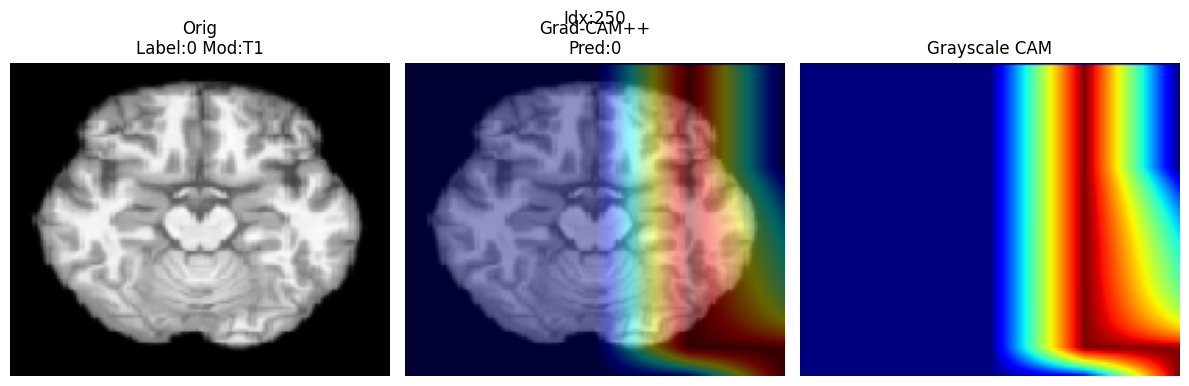

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


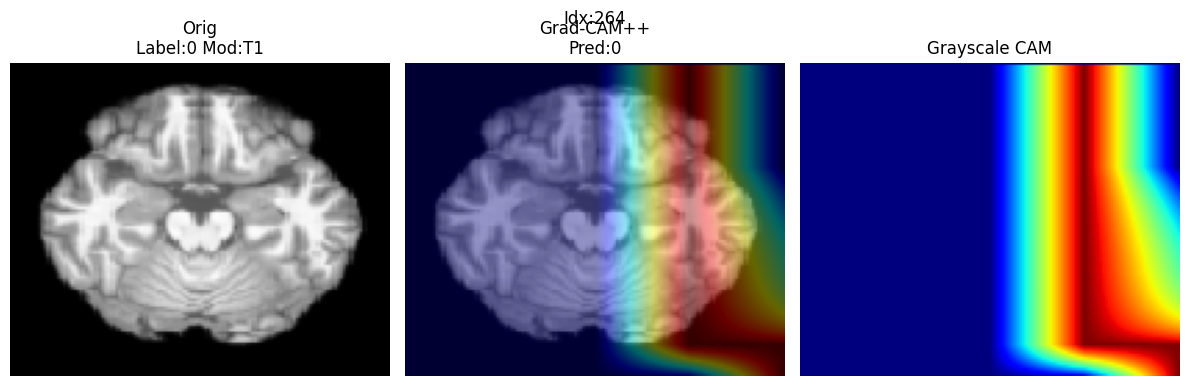

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


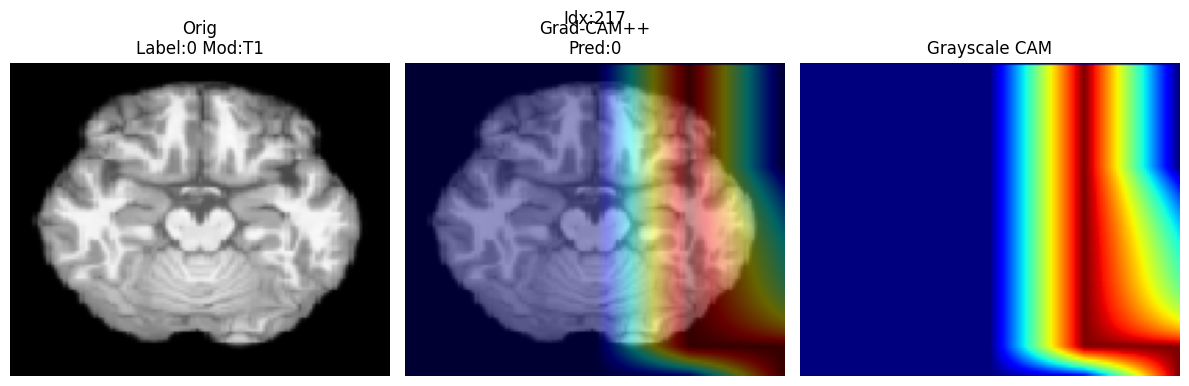

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


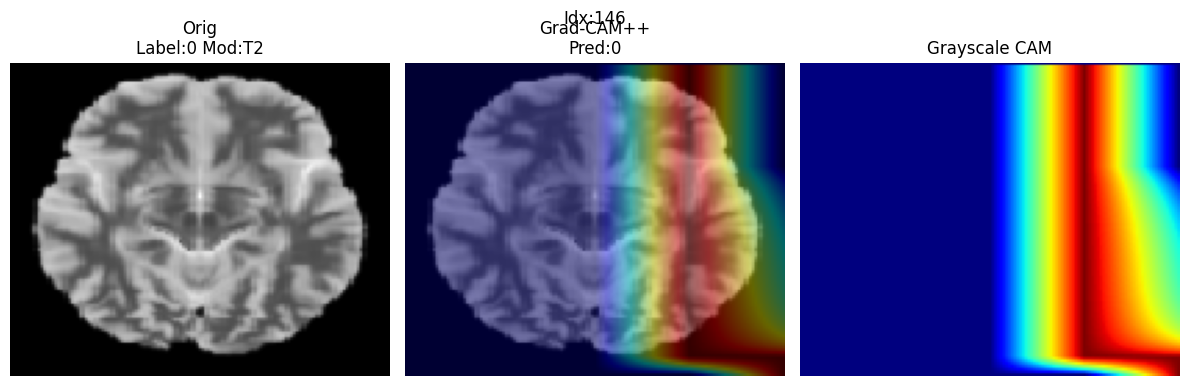

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


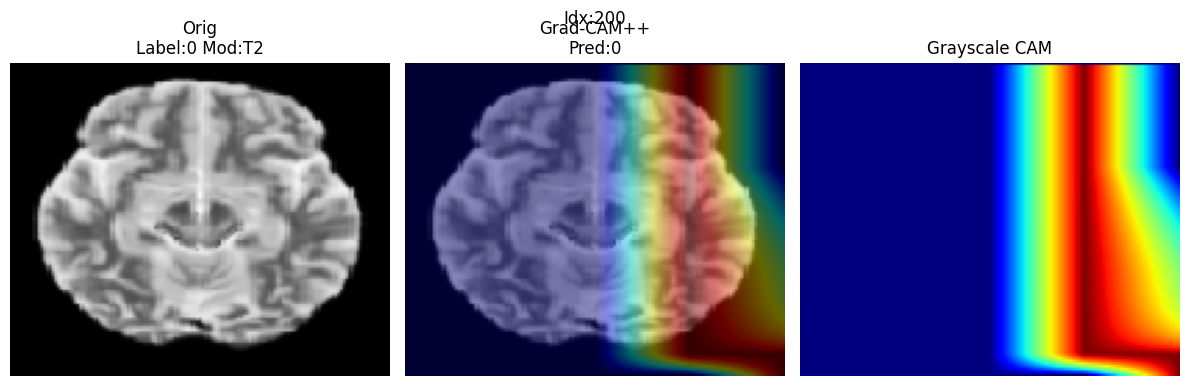

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


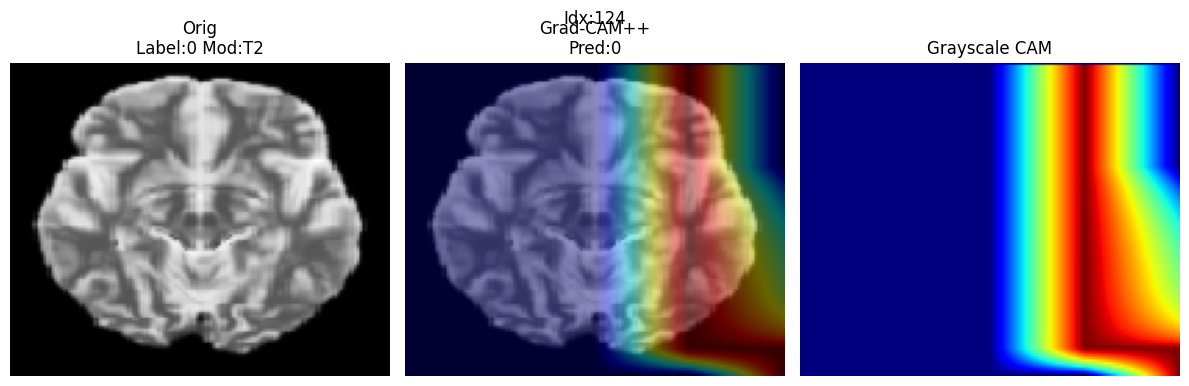

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


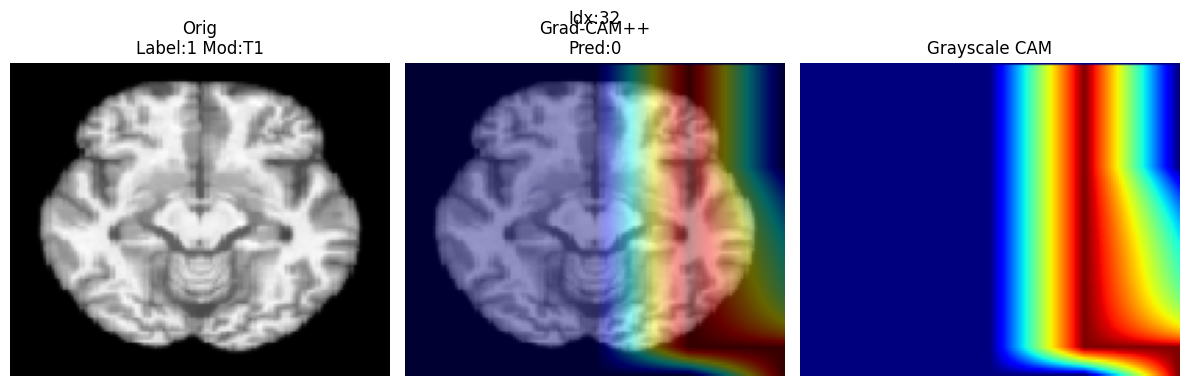

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


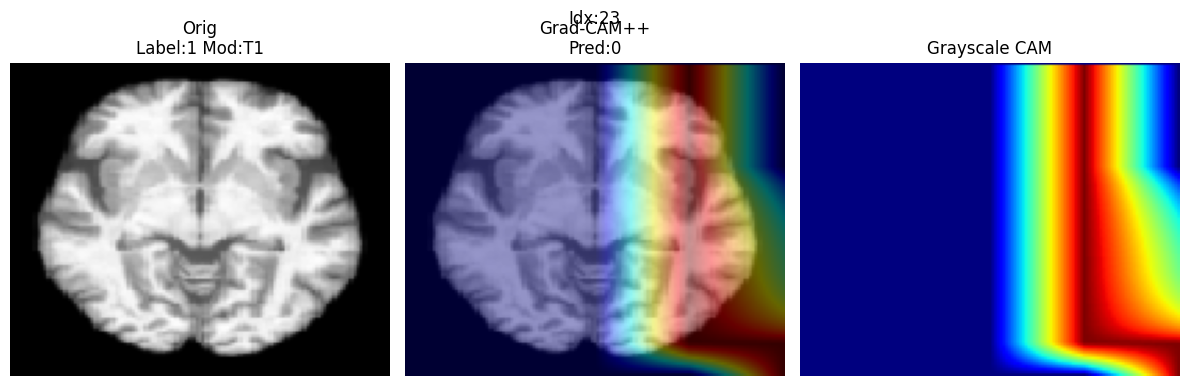

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


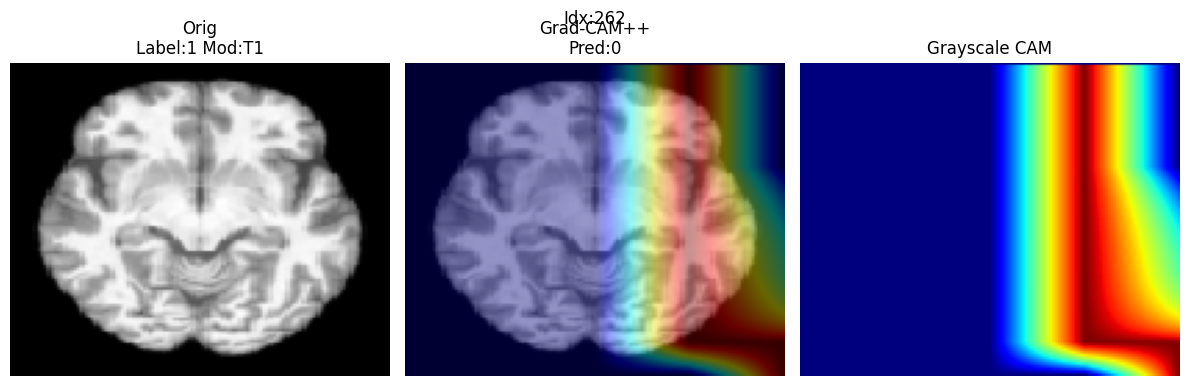

Saved Grad-CAM++ visualizations to /content/drive/MyDrive/ResNet50_PDvsHC/explainability_outputs


In [47]:

# 7) Run Grad-CAM++ on a sample of test images and save results
OUT_DIR = os.path.join(DRIVE_SAVE_DIR, "explainability_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

num_examples = 12  # change as desired
indices = np.arange(len(TEST_IMAGES))
# pick stratified by class and modality: choose equal numbers
sel_idx = []
for lab in [0,1]:
    for mod in ['T1','T2']:
        mask = np.where((TEST_LABELS==lab) & (mod_str==mod))[0]
        if len(mask) == 0: continue
        pick = np.random.choice(mask, min(3, len(mask)), replace=False).tolist()  # up to 3 each bucket
        sel_idx += pick
sel_idx = sel_idx[:num_examples]

print("Selected indices for explainability:", sel_idx)

gradcam_results = []
for i in sel_idx:
    img = TEST_IMAGES[i]
    lab = int(TEST_LABELS[i])
    mod = mod_str[i]
    overlay, cam_map, pred = compute_and_show_gradcam(img, class_idx=None)
    # plot side-by-side original, overlay, cam
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img); axes[0].set_title(f"Orig\nLabel:{lab} Mod:{mod}"); axes[0].axis('off')
    axes[1].imshow(overlay); axes[1].set_title(f"Grad-CAM++\nPred:{pred}"); axes[1].axis('off')
    axes[2].imshow(cam_map, cmap='jet'); axes[2].set_title('Grayscale CAM'); axes[2].axis('off')
    plt.suptitle(f"Idx:{i}")
    plt.tight_layout()
    savep = os.path.join(OUT_DIR, f"gradcam_idx{i}_lab{lab}_mod{mod}_pred{pred}.png")
    plt.savefig(savep, bbox_inches='tight', dpi=150)
    plt.show()
    gradcam_results.append((i, savep))
print("Saved Grad-CAM++ visualizations to", OUT_DIR)


In [50]:

# 8) SHAP (GradientExplainer) for Keras models
# Notes:
# - GradientExplainer requires a background dataset.
# - Make sure the model input and background are preprocessed the same way as training (we assume [0,1] images).
# - For classification with softmax outputs, shap.GradientExplainer will explain outputs for each logit/class.

# Prepare background (using a subset of test images)
bg_size = min(32, len(TEST_IMAGES))
background = np.stack([preprocess_image_np(TEST_IMAGES[i])[0] for i in np.random.choice(len(TEST_IMAGES), bg_size, replace=False)], axis=0)  # [N,H,W,3]

# Create a GradientExplainer with the Keras model and background data
# For Keras models with softmax output, SHAP needs the model and background data.
# We also need to specify the layer to compute gradients with respect to.
# By default, it computes gradients with respect to the input.
try:
    # If the model's output layer has a name like 'dense', we can use that,
    # or we can let GradientExplainer handle it based on the model structure.
    # Passing the model and background should be sufficient for most Keras models.
    explainer = shap.GradientExplainer(model, background)
except Exception as e:
     print(f"Error initializing GradientExplainer: {e}")
     explainer = None # Set explainer to None if initialization fails

if explainer is not None:
    # Choose a few test images to explain
    shap_sel_idx = sel_idx[:6]  # reuse some from Grad-CAM selection
    to_explain = np.stack([preprocess_image_np(TEST_IMAGES[i])[0] for i in shap_sel_idx], axis=0)  # [k,H,W,3]

    # Compute SHAP values (list of arrays per output class)
    # If the model has multiple outputs, shap_values will be a list of arrays.
    # For binary classification with softmax, it's usually a list of two arrays, one for each class.
    print("Computing SHAP values...")
    shap_values = explainer.shap_values(to_explain)  # returns list length=num_classes, each (k,H,W,3)
    print("SHAP values computed.")

    # Plot SHAP image plots for predicted class (class 1 typically = PD)
    # shap.image_plot expects values shaped (num_explanations, H, W, C) per class; it can accept list of arrays
    # We'll plot class 1 explanations if shap_values is a list of shape (num_classes, num_explanations, H, W, C)
    shap_dir = os.path.join(OUT_DIR, "shap")
    os.makedirs(shap_dir, exist_ok=True)


Computing SHAP values...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
SHAP values computed.


Loading model from: /content/drive/MyDrive/ResNet50_PDvsHC/best_full_model.keras
TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 113, 137,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 119, 143,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 57, 69,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 57, 69,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 57, 69,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 59, 71,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 29, 35,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 29, 35,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 29, 35,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 29, 35,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 29, 35,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 29, 35,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 29, 35,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 29, 35,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 29, 35,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 29, 35,    │      1,024 │ conv2_block1_3_c

 Total params: 70,669,192 (269.58 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,077,382 (179.59 MB)

Using in-memory testX array of shape (268, 113, 137, 3)
Selected indices for explainability: [197, 58, 257, 70, 94, 200, 266, 176, 34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


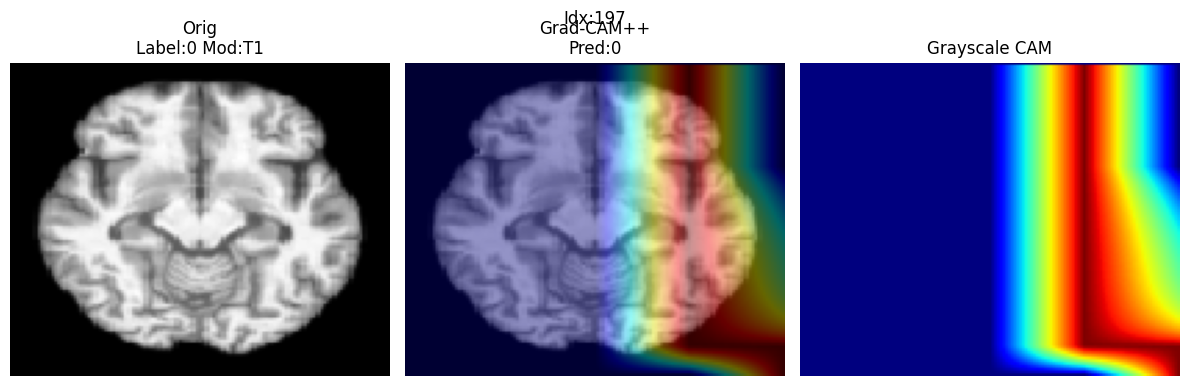

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


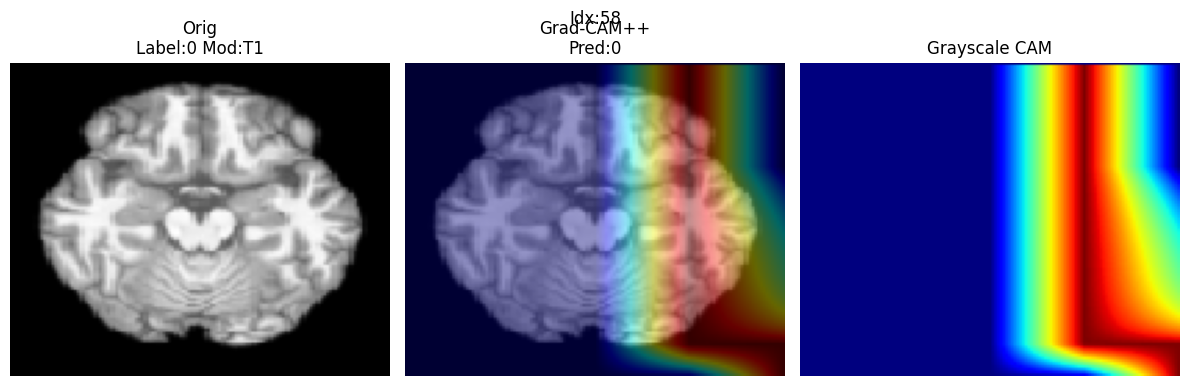

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


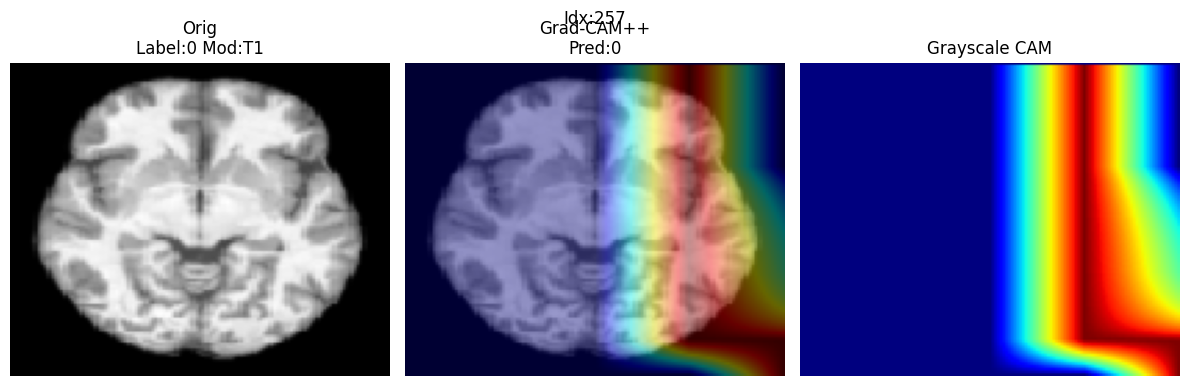

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


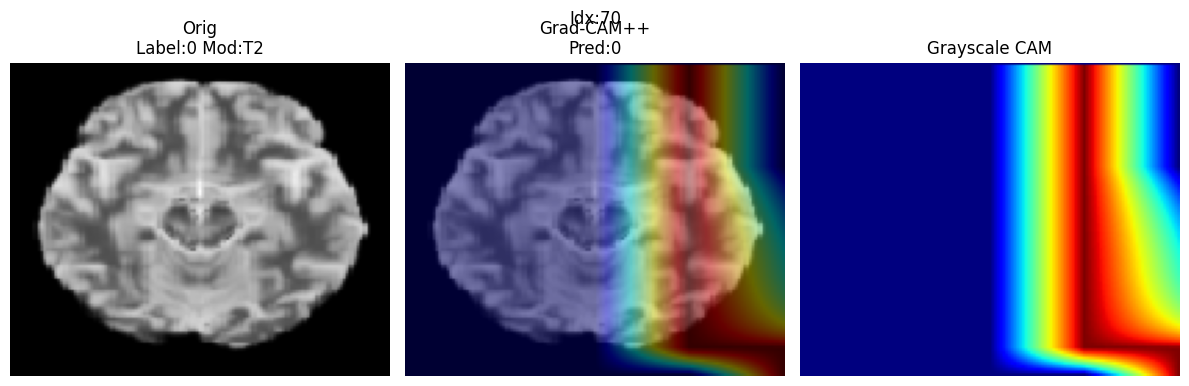

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


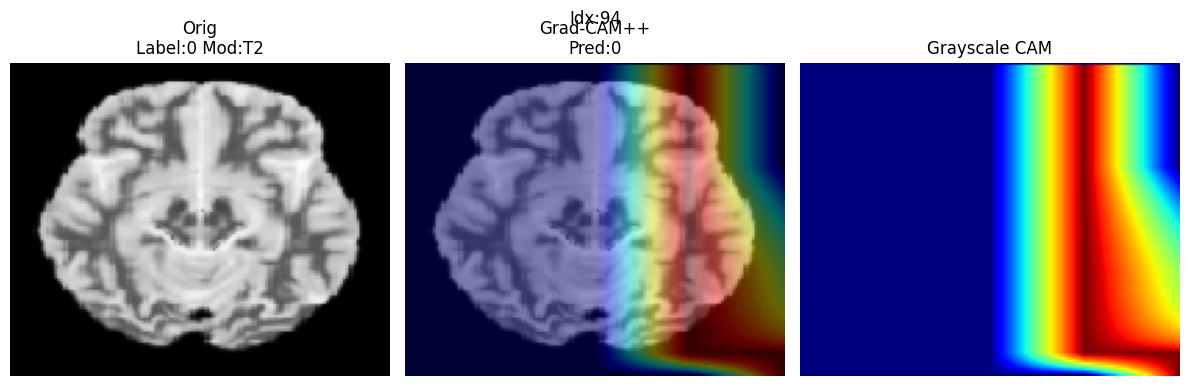

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


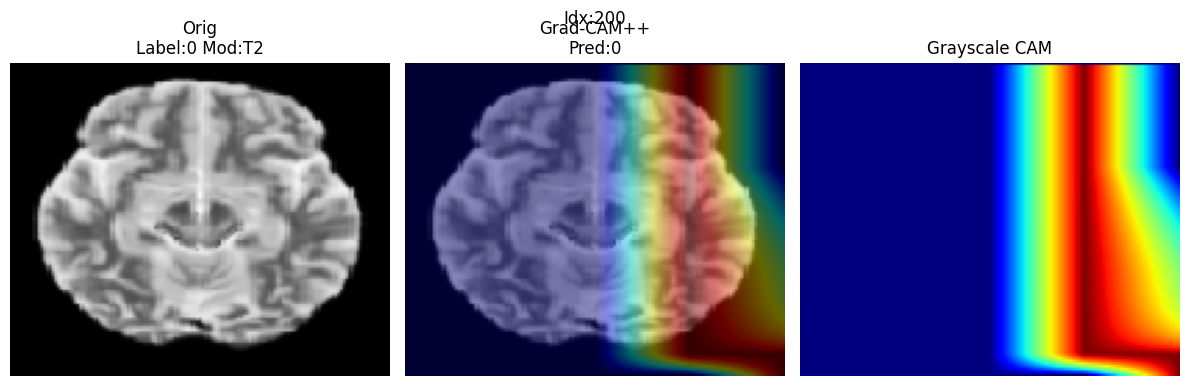

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


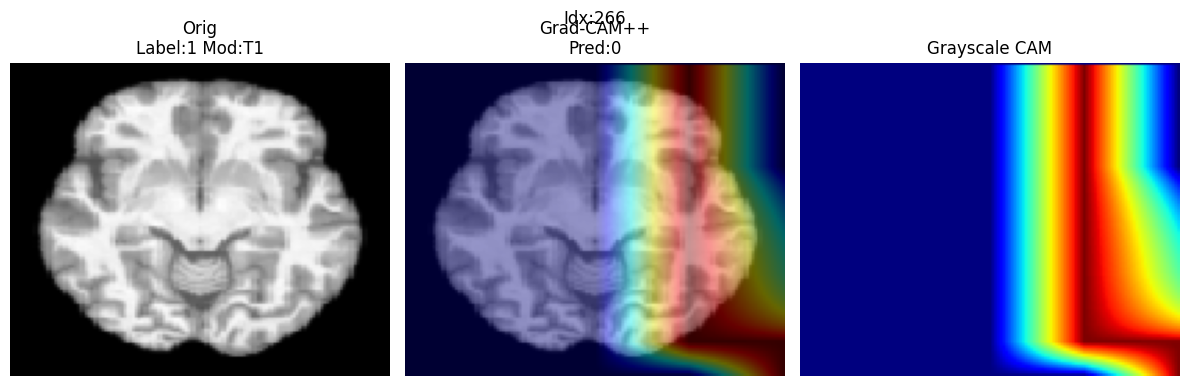

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


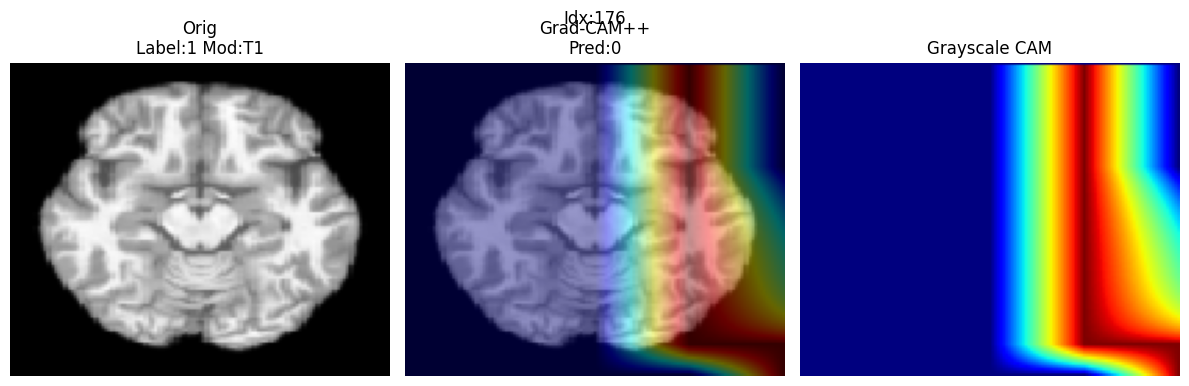

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


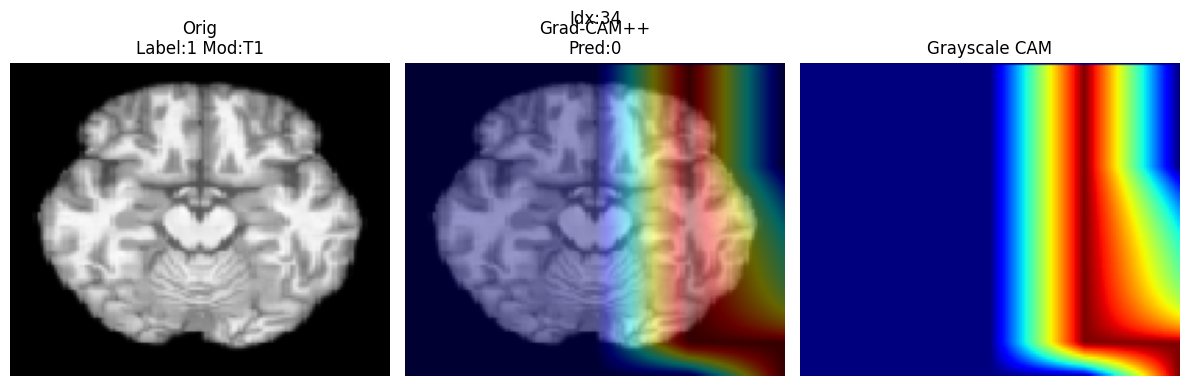

Saved Grad-CAM++ visualizations to /content/drive/MyDrive/ResNet50_PDvsHC/explainability_outputs
Computing SHAP values...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('i', 'self'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
SHAP values computed.
Unexpected SHAP values format. Cannot plot.
Module 4 complete — Grad-CAM++ and SHAP visualizations saved in Drive.


In [53]:
# ============================
# MODULE 4: Explainability - Grad-CAM++ (tf-keras-vis) + SHAP
# ============================

# 0) Install required libs (run once)
!pip install -q tf-keras-vis==0.8.7 shap==0.42.1 matplotlib opencv-python

# 1) Imports
import os, numpy as np, matplotlib.pyplot as plt, cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras import backend as K
import shap

# tf-keras-vis imports
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize

# 2) Paths & device check
DRIVE_SAVE_DIR = "/content/drive/MyDrive/ResNet50_PDvsHC"
BEST_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, "best_full_model.keras")  # adjust if different
FINAL_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, "final_best_model.keras")  # fallback
if not os.path.exists(BEST_MODEL_PATH):
    if os.path.exists(FINAL_MODEL_PATH):
        BEST_MODEL_PATH = FINAL_MODEL_PATH
print("Loading model from:", BEST_MODEL_PATH)

print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# 3) Load model
# If you used mixed precision and saved custom dtype, this should still load. If it errors, try custom_objects.
model = load_model(BEST_MODEL_PATH)
model.summary()

# 4) Helpers: preprocess / deprocess images (match training preprocessing)
# If training normalized images to [0,1], we will use that. If you normalized with ImageNet mean/std, replicate here.
# Module 1 used images in [0,1] (divided by 255). Module2 used ResNet50 (imagenet weights) which expects images scaled as:
#   either [-1,1] or with imagemtn mean/std. We assume you used [0,1] during training (Module1). If you used ImageNet preprocess, replace with tf.keras.applications.resnet50.preprocess_input

def preprocess_image_np(img_np, target_size=None):
    """ img_np: HxWxC in range [0,1] or 0-255. Returns batched float32 [1,H,W,C] in same scale as training """
    if img_np.max() > 1.1:
        img_np = img_np.astype(np.float32) / 255.0
    if target_size is not None:
        img_np = cv2.resize(img_np, (target_size[1], target_size[0]), interpolation=cv2.INTER_AREA)
    # ensure shape HWC and 3 channels
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    if img_np.shape[2] == 1:
        img_np = np.concatenate([img_np]*3, axis=-1)
    return np.expand_dims(img_np.astype(np.float32), axis=0)

def deprocess_for_display(img_batch):
    """ img_batch: [B,H,W,C] in [0,1] -> return HxW x3 in [0,1] """
    img = img_batch[0]
    img = np.clip(img, 0, 1)
    return img

# 5) Prepare a small test subset for explanation
# If you have testX as numpy images and testM as modalities array (e.g., "T1"/"T2" or 0/1), use them.
# Otherwise, if you only have file paths, adapt to load from the paths.

# We'll try to use testX variable if available in workspace (from Module 1/3)
try:
    _ = testX
    print("Using in-memory testX array of shape", testX.shape)
    TEST_IMAGES = testX  # numpy [N,H,W,3]
    TEST_LABELS = np.array(y_test_int)
    TEST_MODALITIES = np.array(testM)
except Exception as e:
    # Replace this with code to load images from file paths if you don't have testX
    raise RuntimeError("testX not found in workspace. Please load your test images as numpy array testX, labels y_test_int, modalities testM.") from e

# Convert modalities to readable form if necessary
mod_arr = np.array(TEST_MODALITIES)
if mod_arr.dtype.kind in 'i':
    # assume 0=T1,1=T2
    mod_str = np.array(['T1' if m==0 else 'T2' for m in mod_arr])
else:
    mod_str = mod_arr

# 6) Grad-CAM++ setup using tf-keras-vis
# Replace final activation with linear for saliency computation (tf-keras-vis helper does this)
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=False)

# utility to run gradcam++ and return heatmap overlay
def compute_and_show_gradcam(img_np, class_idx=None, grayscale_cam_blend=0.5):
    """
    img_np: HxWxC in [0,1] (unbatched)
    class_idx: int class to explain (0 or 1). If None, model prediction will be used.
    returns: visualization image (H,W,3), grayscale_cam map
    """
    H, W = img_np.shape[:2]
    inp = preprocess_image_np(img_np, target_size=(H,W))  # returns [1,H,W,3]
    # model_pred
    preds = model.predict(inp)
    if preds.ndim == 2 and preds.shape[1] == 2:
        pred_class = int(np.argmax(preds[0]))
    else:
        pred_class = int((preds.ravel() > 0.5).astype(int))
    if class_idx is None:
        class_idx = pred_class
    # score function for class index
    score = CategoricalScore([class_idx])
    # compute cam (returns [batch, H, W])
    cam = gradcam(score, inp, penultimate_layer=-1)  # penultimate_layer can be set, -1 uses last conv layer
    grayscale_cam = cam[0]  # HxW
    # normalize cam to 0..1
    grayscale_cam = normalize(grayscale_cam)
    # overlay heatmap on original image (convert to uint8)
    img_disp = (img_np * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap((grayscale_cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.6 * img_disp + 0.4 * heatmap).astype(np.uint8)
    return overlay, grayscale_cam, pred_class

# 7) Run Grad-CAM++ on a sample of test images and save results
OUT_DIR = os.path.join(DRIVE_SAVE_DIR, "explainability_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

num_examples = 12  # change as desired
indices = np.arange(len(TEST_IMAGES))
# pick stratified by class and modality: choose equal numbers
sel_idx = []
for lab in [0,1]:
    for mod in ['T1','T2']:
        mask = np.where((TEST_LABELS==lab) & (mod_str==mod))[0]
        if len(mask) == 0: continue
        pick = np.random.choice(mask, min(3, len(mask)), replace=False).tolist()  # up to 3 each bucket
        sel_idx += pick
sel_idx = sel_idx[:num_examples]

print("Selected indices for explainability:", sel_idx)

gradcam_results = []
for i in sel_idx:
    img = TEST_IMAGES[i]
    lab = int(TEST_LABELS[i])
    mod = mod_str[i]
    overlay, cam_map, pred = compute_and_show_gradcam(img, class_idx=None)
    # plot side-by-side original, overlay, cam
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img); axes[0].set_title(f"Orig\nLabel:{lab} Mod:{mod}"); axes[0].axis('off')
    axes[1].imshow(overlay); axes[1].set_title(f"Grad-CAM++\nPred:{pred}"); axes[1].axis('off')
    axes[2].imshow(cam_map, cmap='jet'); axes[2].set_title('Grayscale CAM'); axes[2].axis('off')
    plt.suptitle(f"Idx:{i}")
    plt.tight_layout()
    savep = os.path.join(OUT_DIR, f"gradcam_idx{i}_lab{lab}_mod{mod}_pred{pred}.png")
    plt.savefig(savep, bbox_inches='tight', dpi=150)
    plt.show()
    gradcam_results.append((i, savep))
print("Saved Grad-CAM++ visualizations to", OUT_DIR)


# 8) SHAP (GradientExplainer) for Keras models
# Notes:
# - GradientExplainer requires a background dataset.
# - Make sure the model input and background are preprocessed the same way as training (we assume [0,1] images).
# - For classification with softmax outputs, shap.GradientExplainer will explain outputs for each logit/class.

# Prepare background (using a subset of test images)
bg_size = min(32, len(TEST_IMAGES))
background = np.stack([preprocess_image_np(TEST_IMAGES[i])[0] for i in np.random.choice(len(TEST_IMAGES), bg_size, replace=False)], axis=0)  # [N,H,W,3]

# Create a GradientExplainer with the Keras model and background data
# For Keras models with softmax output, SHAP needs the model and background data.
# We also need to specify the layer to compute gradients with respect to.
# By default, it computes gradients with respect to the input.
try:
    # If the model's output layer has a name like 'dense', we can use that,
    # or we can let GradientExplainer handle it based on the model structure.
    # Passing the model and background should be sufficient for most Keras models.
    explainer = shap.GradientExplainer(model, background)
except Exception as e:
     print(f"Error initializing GradientExplainer: {e}")
     explainer = None # Set explainer to None if initialization fails

if explainer is not None:
    # Choose a few test images to explain
    shap_sel_idx = sel_idx[:6]  # reuse some from Grad-CAM selection
    to_explain = np.stack([preprocess_image_np(TEST_IMAGES[i])[0] for i in shap_sel_idx], axis=0)  # [k,H,W,3]

    # Compute SHAP values (list of arrays per output class)
    # If the model has multiple outputs, shap_values will be a list of arrays.
    # For binary classification with softmax, it's usually a list of two arrays, one for each class.
    print("Computing SHAP values...")
    shap_values = explainer.shap_values(to_explain)  # returns list length=num_classes, each (k,H,W,3)
    print("SHAP values computed.")

    # Plot SHAP image plots for predicted class (class 1 typically = PD)
    # shap.image_plot expects values shaped (num_explanations, H, W, C) per class; it can accept list of arrays
    # We'll plot class 1 explanations if shap_values is a list of shape (num_classes, num_explanations, H, W, C)
    shap_dir = os.path.join(OUT_DIR, "shap")
    os.makedirs(shap_dir, exist_ok=True)

    # Check the structure of shap_values
    if isinstance(shap_values, list) and len(shap_values) > 1 and shap_values[1].ndim == 4:
        # Assuming shap_values is a list where shap_values[1] corresponds to the positive class
        print("Plotting SHAP values for class 1...")
        # Save individual SHAP visualizations per image (class 1)
        for idx_i, sample_idx in enumerate(shap_sel_idx):
            orig = to_explain[idx_i]  # [H,W,3]
            sv = shap_values[1][idx_i]  # Get SHAP values for class 1 for this sample [H,W,3]

            # Ensure sv has 3 channels for plotting if needed
            if sv.shape[-1] == 1:
                sv = np.concatenate([sv]*3, axis=-1)
            elif sv.shape[-1] != 3:
                 # If not 1 or 3 channels, plot a single channel (e.g., the first one)
                 sv = sv[..., 0:1] # Extract the first channel
                 sv = np.concatenate([sv]*3, axis=-1) # Duplicate to 3 channels for display

            # For image plots, SHAP often visualizes channel 0 or the average across channels
            # We'll use the sum across channels for simplicity in this visualization
            sv_sum = np.sum(sv, axis=-1) # [H,W]
            sv_sum_norm = (sv_sum - sv_sum.min()) / (sv_sum.max() - sv_sum.min() + 1e-9)

            # Overlay positive contributions (e.g., high SHAP values) in red
            red_overlay = np.zeros_like(orig)
            # Simple approach: color pixels with high positive SHAP sum
            red_overlay[sv_sum_norm > 0.7, 0] = 1.0 # Threshold for high positive values
            # More sophisticated: use a colormap on the SHAP values
            # shap.force_plot or image_plot are better for proper visualization, but we're doing a simple overlay here

            # A better overlay using absolute SHAP values for intensity and sign for color
            # Here's a basic example focusing on positive values
            abs_sv_sum = np.abs(sv_sum)
            abs_sv_norm = (abs_sv_sum - abs_sv_sum.min()) / (abs_sv_sum.max() - abs_sv_sum.min() + 1e-9)

            # Create a heatmap from SHAP values (e.g., using sum across channels)
            heatmap = cv2.applyColorMap((abs_sv_norm*255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

            # Blend original image with heatmap, adjusting transparency based on SHAP value magnitude and sign
            # A simple blend, can be improved
            overlay_blend = (0.6 * (orig * 255) + 0.4 * heatmap).astype(np.uint8) # Simple blend


            fig, ax = plt.subplots(1,3, figsize=(12,4))
            ax[0].imshow(orig); ax[0].set_title(f"Orig idx {sample_idx}"); ax[0].axis('off')
            ax[1].imshow(sv_sum, cmap='seismic', vmin=-np.max(np.abs(sv_sum)), vmax=np.max(np.abs(sv_sum))); ax[1].set_title('SHAP map (Sum across channels)'); ax[1].axis('off')
            ax[2].imshow(overlay_blend); ax[2].set_title('Overlay (Absolute SHAP intensity)'); ax[2].axis('off')
            plt.suptitle(f"SHAP Explanation for Sample {sample_idx} (Class 1)")
            plt.tight_layout()
            savep = os.path.join(shap_dir, f"shap_idx{sample_idx}_class1.png")
            plt.savefig(savep, bbox_inches='tight', dpi=150)
            plt.show()

        print("Saved SHAP visualizations to", shap_dir)
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 4:
         # If shap_values is a single array (e.g., for regression or single output)
        print("Plotting SHAP values...")
        for idx_i, sample_idx in enumerate(shap_sel_idx):
            orig = to_explain[idx_i]  # [H,W,3]
            sv = shap_values[idx_i] # Get SHAP values for this sample [H,W,3]

            # Ensure sv has 3 channels for plotting if needed
            if sv.shape[-1] == 1:
                sv = np.concatenate([sv]*3, axis=-1)
            elif sv.shape[-1] != 3:
                 sv = sv[..., 0:1] # Extract the first channel
                 sv = np.concatenate([sv]*3, axis=-1) # Duplicate to 3 channels

            sv_sum = np.sum(sv, axis=-1) # [H,W]
            abs_sv_sum = np.abs(sv_sum)
            abs_sv_norm = (abs_sv_sum - abs_sv_norm.min()) / (abs_sv_norm.max() - abs_sv_norm.min() + 1e-9) # Normalize absolute values


            heatmap = cv2.applyColorMap((abs_sv_norm*255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

            overlay_blend = (0.6 * (orig * 255) + 0.4 * heatmap).astype(np.uint8)


            fig, ax = plt.subplots(1,3, figsize=(12,4))
            ax[0].imshow(orig); ax[0].set_title(f"Orig idx {sample_idx}"); ax[0].axis('off')
            ax[1].imshow(sv_sum, cmap='seismic', vmin=-np.max(np.abs(sv_sum)), vmax=np.max(np.abs(sv_sum))); ax[1].set_title('SHAP map (Sum across channels)'); ax[1].axis('off')
            ax[2].imshow(overlay_blend); ax[2].set_title('Overlay (Absolute SHAP intensity)'); ax[2].axis('off')
            plt.suptitle(f"SHAP Explanation for Sample {sample_idx}")
            plt.tight_layout()
            savep = os.path.join(shap_dir, f"shap_idx{sample_idx}.png")
            plt.savefig(savep, bbox_inches='tight', dpi=150)
            plt.show()
        # Corrected indentation for this print statement
        print("Saved SHAP visualizations to", shap_dir)

    else:
        print("Unexpected SHAP values format. Cannot plot.")


print("Module 4 complete — Grad-CAM++ and SHAP visualizations saved in Drive.")

Using history and best_model from previous training.


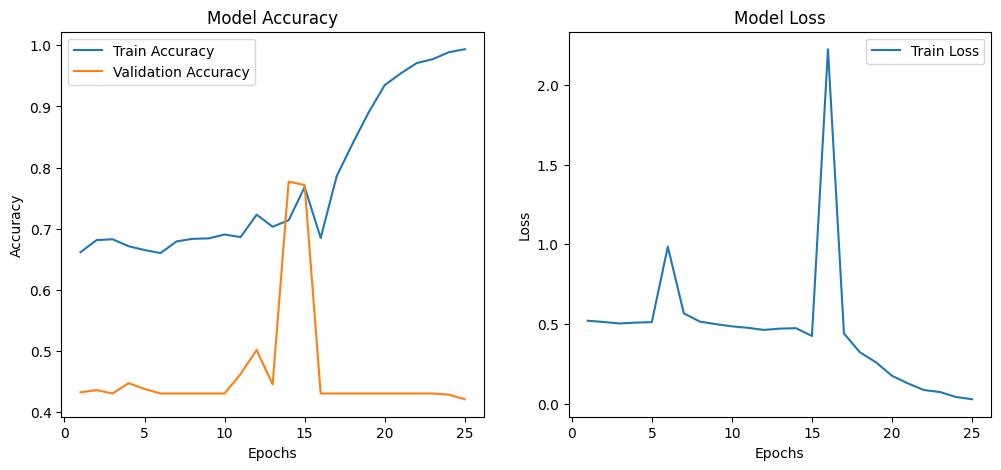

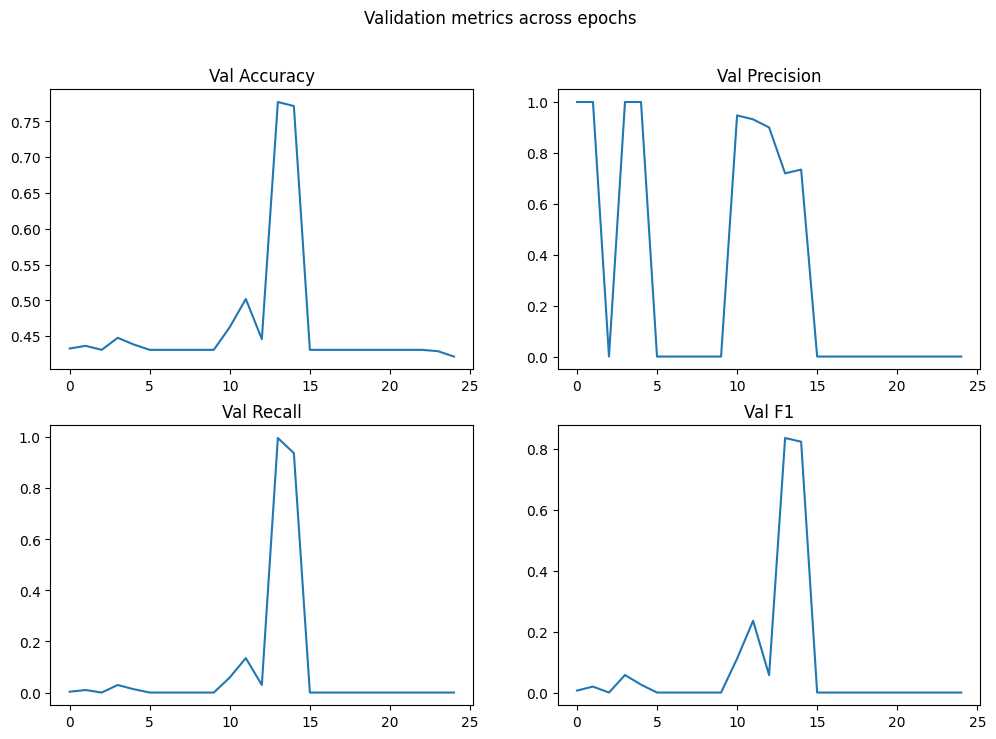

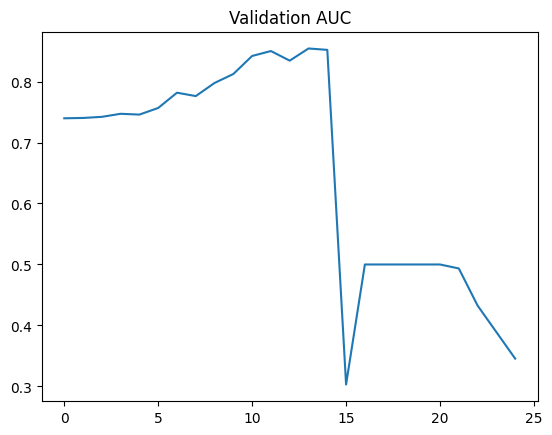


Evaluating on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step


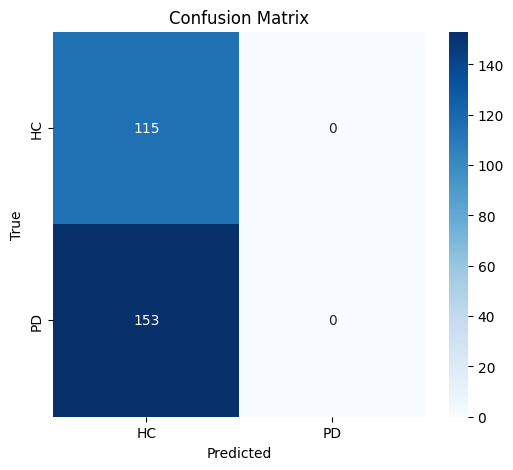


Classification Report:
              precision    recall  f1-score   support

          HC       0.43      1.00      0.60       115
          PD       0.00      0.00      0.00       153

    accuracy                           0.43       268
   macro avg       0.21      0.50      0.30       268
weighted avg       0.18      0.43      0.26       268



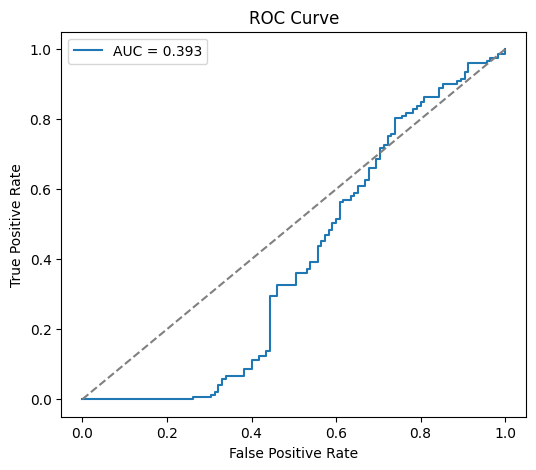

ROC AUC Score: 0.393


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow as tf # Import tensorflow

# Train the model
# Assuming tf_train_ds, valX, and y_val_int are available from previous cells
# history = model.fit(
#     train_generator, # Replace with tf_train_ds
#     validation_data=val_generator, # Replace with (valX, y_val_int)
#     epochs=20,   # you can increase if GPU time allows
#     callbacks=[checkpoint] # Checkpoint callback from Module 2 or 3
# )

# Note: The training was already performed in cell ZWvltVrvAiQa (Module 3).
# This cell is likely intended for plotting results and evaluating on the test set.
# We will use the history and best_model from cell ZWvltVrvAiQa if available.

# Assuming history and best_model are available from cell ZWvltVrvAiQa
try:
    # Assuming h_all and val_hist_all are available from cell ZWvltVrvAiQa
    history = h_all # Use combined history from Module 3
    val_history = val_hist_all # Use combined validation history from PerEpochMetrics
    best_model = tf.keras.models.load_model(best_model_path) # Load the best model saved in Module 3
    print("Using history and best_model from previous training.")
except NameError:
    print("History, val_hist_all or best_model not found. Please ensure previous training cell was run.")
    # If history and best_model are not available, you might need to re-run the training cell ZWvltVrvAiQa
    # Or load a saved model and manually compute metrics.
    # For now, we will proceed with evaluation assuming best_model is loaded.


# Plot Accuracy and Loss curves
# Use the combined history from Module 3 (h_all)
if 'history' in locals() and 'val_history' in locals():
    epochs_range = range(1, len(history['loss'])+1)
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history['accuracy'], label='Train Accuracy')
    # Use val_hist_all for validation accuracy as collected by PerEpochMetrics
    if 'val_acc' in val_history and len(val_history['val_acc']) > 0:
        plt.plot(epochs_range[:len(val_history['val_acc'])], val_history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(epochs_range, history['loss'], label='Train Loss')
     # Use val_hist_all for validation loss as collected by PerEpochMetrics
    if 'val_loss' in val_history and len(val_history['val_loss']) > 0:
        plt.plot(epochs_range[:len(val_history['val_loss'])], val_history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    plt.show()
else:
    print("Training history or validation history not available for plotting.")


# Plot Val precision/recall/f1/auc across epochs
if 'val_history' in locals():
    plt.figure(figsize=(12,8))
    if 'val_acc' in val_history and len(val_history['val_acc']) > 0:
        plt.subplot(2,2,1); plt.plot(val_history['val_acc']); plt.title("Val Accuracy")
    if 'val_precision' in val_history and len(val_history['val_precision']) > 0:
        plt.subplot(2,2,2); plt.plot(val_history['val_precision']); plt.title("Val Precision")
    if 'val_recall' in val_history and len(val_history['val_recall']) > 0:
        plt.subplot(2,2,3); plt.plot(val_history['val_recall']); plt.title("Val Recall")
    if 'val_f1' in val_history and len(val_history['val_f1']) > 0:
        plt.subplot(2,2,4); plt.plot(val_history['val_f1']); plt.title("Val F1")
    plt.suptitle("Validation metrics across epochs")
    plt.show()

    if 'val_auc' in val_history and len(val_history['val_auc']) > 0:
        plt.figure(); plt.plot(val_history['val_auc']); plt.title("Validation AUC"); plt.show()
else:
    print("Validation history not available for plotting.")


# --- Confusion Matrix ---
# Assuming testX and y_test_int are available from previous cells
if 'best_model' in locals() and 'testX' in locals() and 'y_test_int' in locals():
    print("\nEvaluating on test set...")
    # Use best_model to predict on testX
    preds_prob_test = best_model.predict(testX, batch_size=64, verbose=1)
    if preds_prob_test.ndim == 2 and preds_prob_test.shape[1] == 2:
        probs_test = preds_prob_test[:,1]
        y_pred = np.argmax(preds_prob_test, axis=1)
    else:
        probs_test = preds_prob_test.ravel()
        y_pred = (probs_test > 0.5).astype(int)

    y_true = y_test_int

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    # Assuming class names are 'HC' and 'PD'
    class_names = ['HC', 'PD']
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # --- Classification Report ---
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # --- ROC AUC ---
    # Use probs_test for ROC AUC
    roc_auc = roc_auc_score(y_true, probs_test)

    fpr, tpr, thresholds = roc_curve(y_true, probs_test)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print(f"ROC AUC Score: {roc_auc:.3f}")
else:
    print("Test data (testX, y_test_int) or best_model not available for evaluation.")